# (deprecated notebook)

# Tools

In [1]:
from pprint import pprint
import pickle
import pyarrow
from tqdm.notebook import tqdm
from pathlib import Path
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple
import xgboost as xgb

data_dir = Path("/home/cyrille/projects/2022/tuxai/dataset")

def get_df(version: int) -> pd.DataFrame:
    target = data_dir / f"dataset_{version}.parquet"
    if not target.exists():
        print("converting pkl to parquet")
        with open(target.with_suffix(".pkl"), "rb") as f:
            df = pickle.load(f)
            df.vmlinux /= (1024 * 1024)
            df.vmlinux = df.vmlinux.astype("float")
            for col in tqdm([col for col in df.columns if col != "vmlinux"]):
                # df[col] = df[col].astype("category")
                df[col] = df[col].astype("bool")
        
        df.to_parquet(target, engine="pyarrow")
    return pd.read_parquet(target, engine="pyarrow").drop_duplicates()  
            
            

# precompute
#for v in (413, 415, 420, 500, 504, 507, 508):
#    get_df(v)

def tuxai_train_test_split(version: int=413, test_size: float=0.2) -> Tuple[pd.DataFrame]:
    df = get_df(version)
    df_train, df_test = train_test_split(df, test_size=test_size)
    options = [col for col in df.columns if col != "vmlinux"]
    X_train = df_train[options]
    y_train = df_train.vmlinux
    X_test = df_test[options]
    y_test = df_test.vmlinux
    return X_train, y_train, X_test, y_test

# X_train, y_train, X_test, y_test = tuxai_train_test_split()

def plot_pred_true(y_pred, y_test):
    fig, ax =plt.subplots(figsize=(20, 8))
    df_ap = pd.DataFrame({
            "actual": y_test,
            "predicted": y_pred,
            "error": abs(y_test - y_pred)
        }).sort_values("actual", ascending=True).reset_index()
    sns.scatterplot(df_ap.predicted, ax=ax, s=1, color="k", label="predicted")
    sns.lineplot(df_ap.actual, ax=ax, alpha=0.5, label="actual")
    sns.scatterplot(df_ap.error, ax=ax, s=1, color="r", label= "error")
    

from sklearn.metrics import mean_squared_error, max_error, accuracy_score
def report(y_pred, y_test):
    return {
        "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
        "max_error": max_error(y_test, y_pred)
    }    


In [20]:
df = get_df(413)

In [25]:

"""
"GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", 
"BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", 
"LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"

"""
df["GZIP-vmlinux"]


0        True
1        True
2        True
3        True
4        True
         ... 
92543    True
92544    True
92545    True
92546    True
92554    True
Name: GZIP-vmlinux, Length: 92502, dtype: bool

# Exp 1.a: XGBOOST (random hp), no feature selection, 4.13 (Baseline)
## (regularizing gradient boosting ~ Random forest)

   - Clever penalization of trees
   - A proportional shrinking of leaf nodes
   - Newton Boosting
   - Extra randomization parameter
   - Implementation on single, distributed systems and out-of-core computation
   - Automatic Feature selection

In [ ]:
X_train, y_train, X_test, y_test = tuxai_train_test_split()
# dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)
params = {
    "max_depth": 5,
    "alpha": 10,
    "learning_rate": 0.1,
    "n_estimators":100,
    "eval_metric": "rmse"
}

xgb_reg = xgb.XGBRegressor(**params)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)

{'max_error': 396.55072021484375, 'rmse': 12.164388107230847}


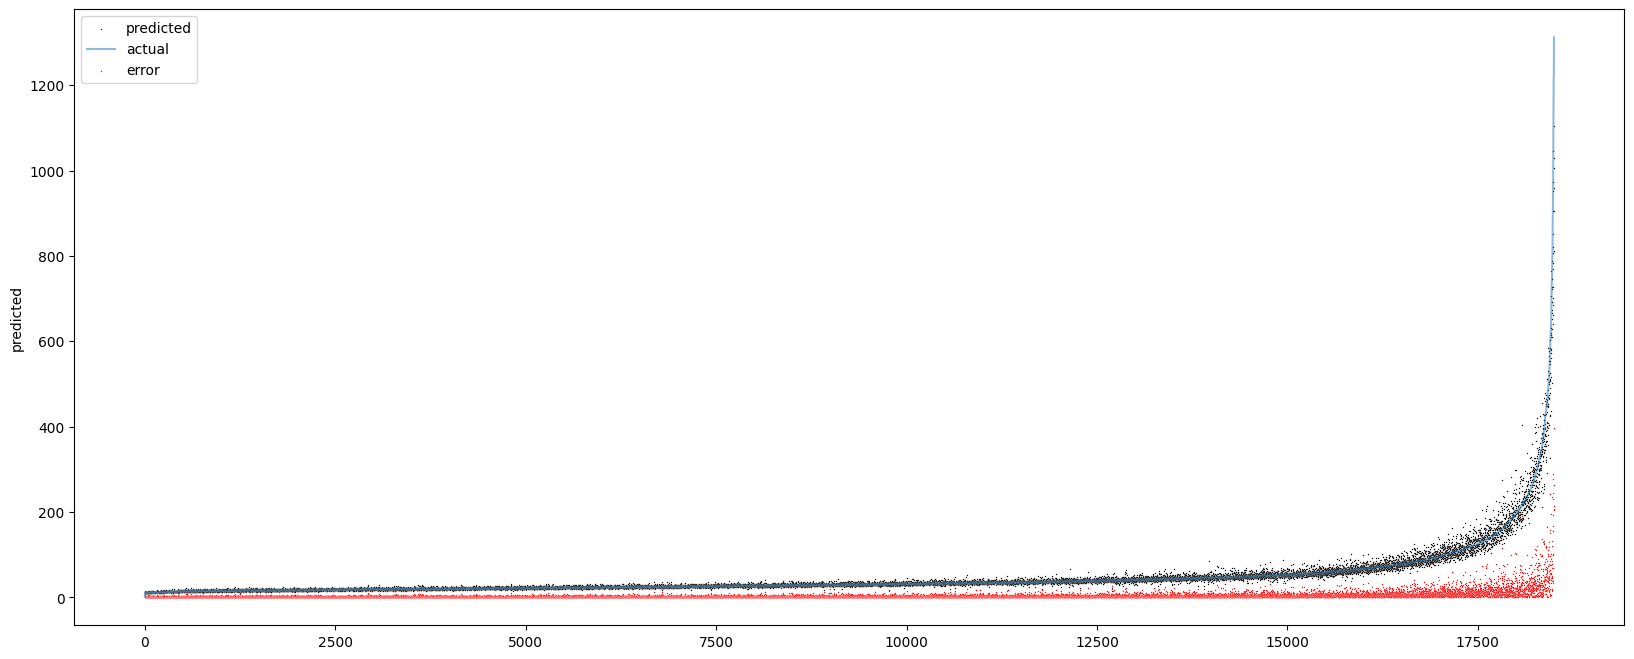

In [6]:
pprint(report(y_pred, y_test))
plot_pred_true(y_pred, y_test)

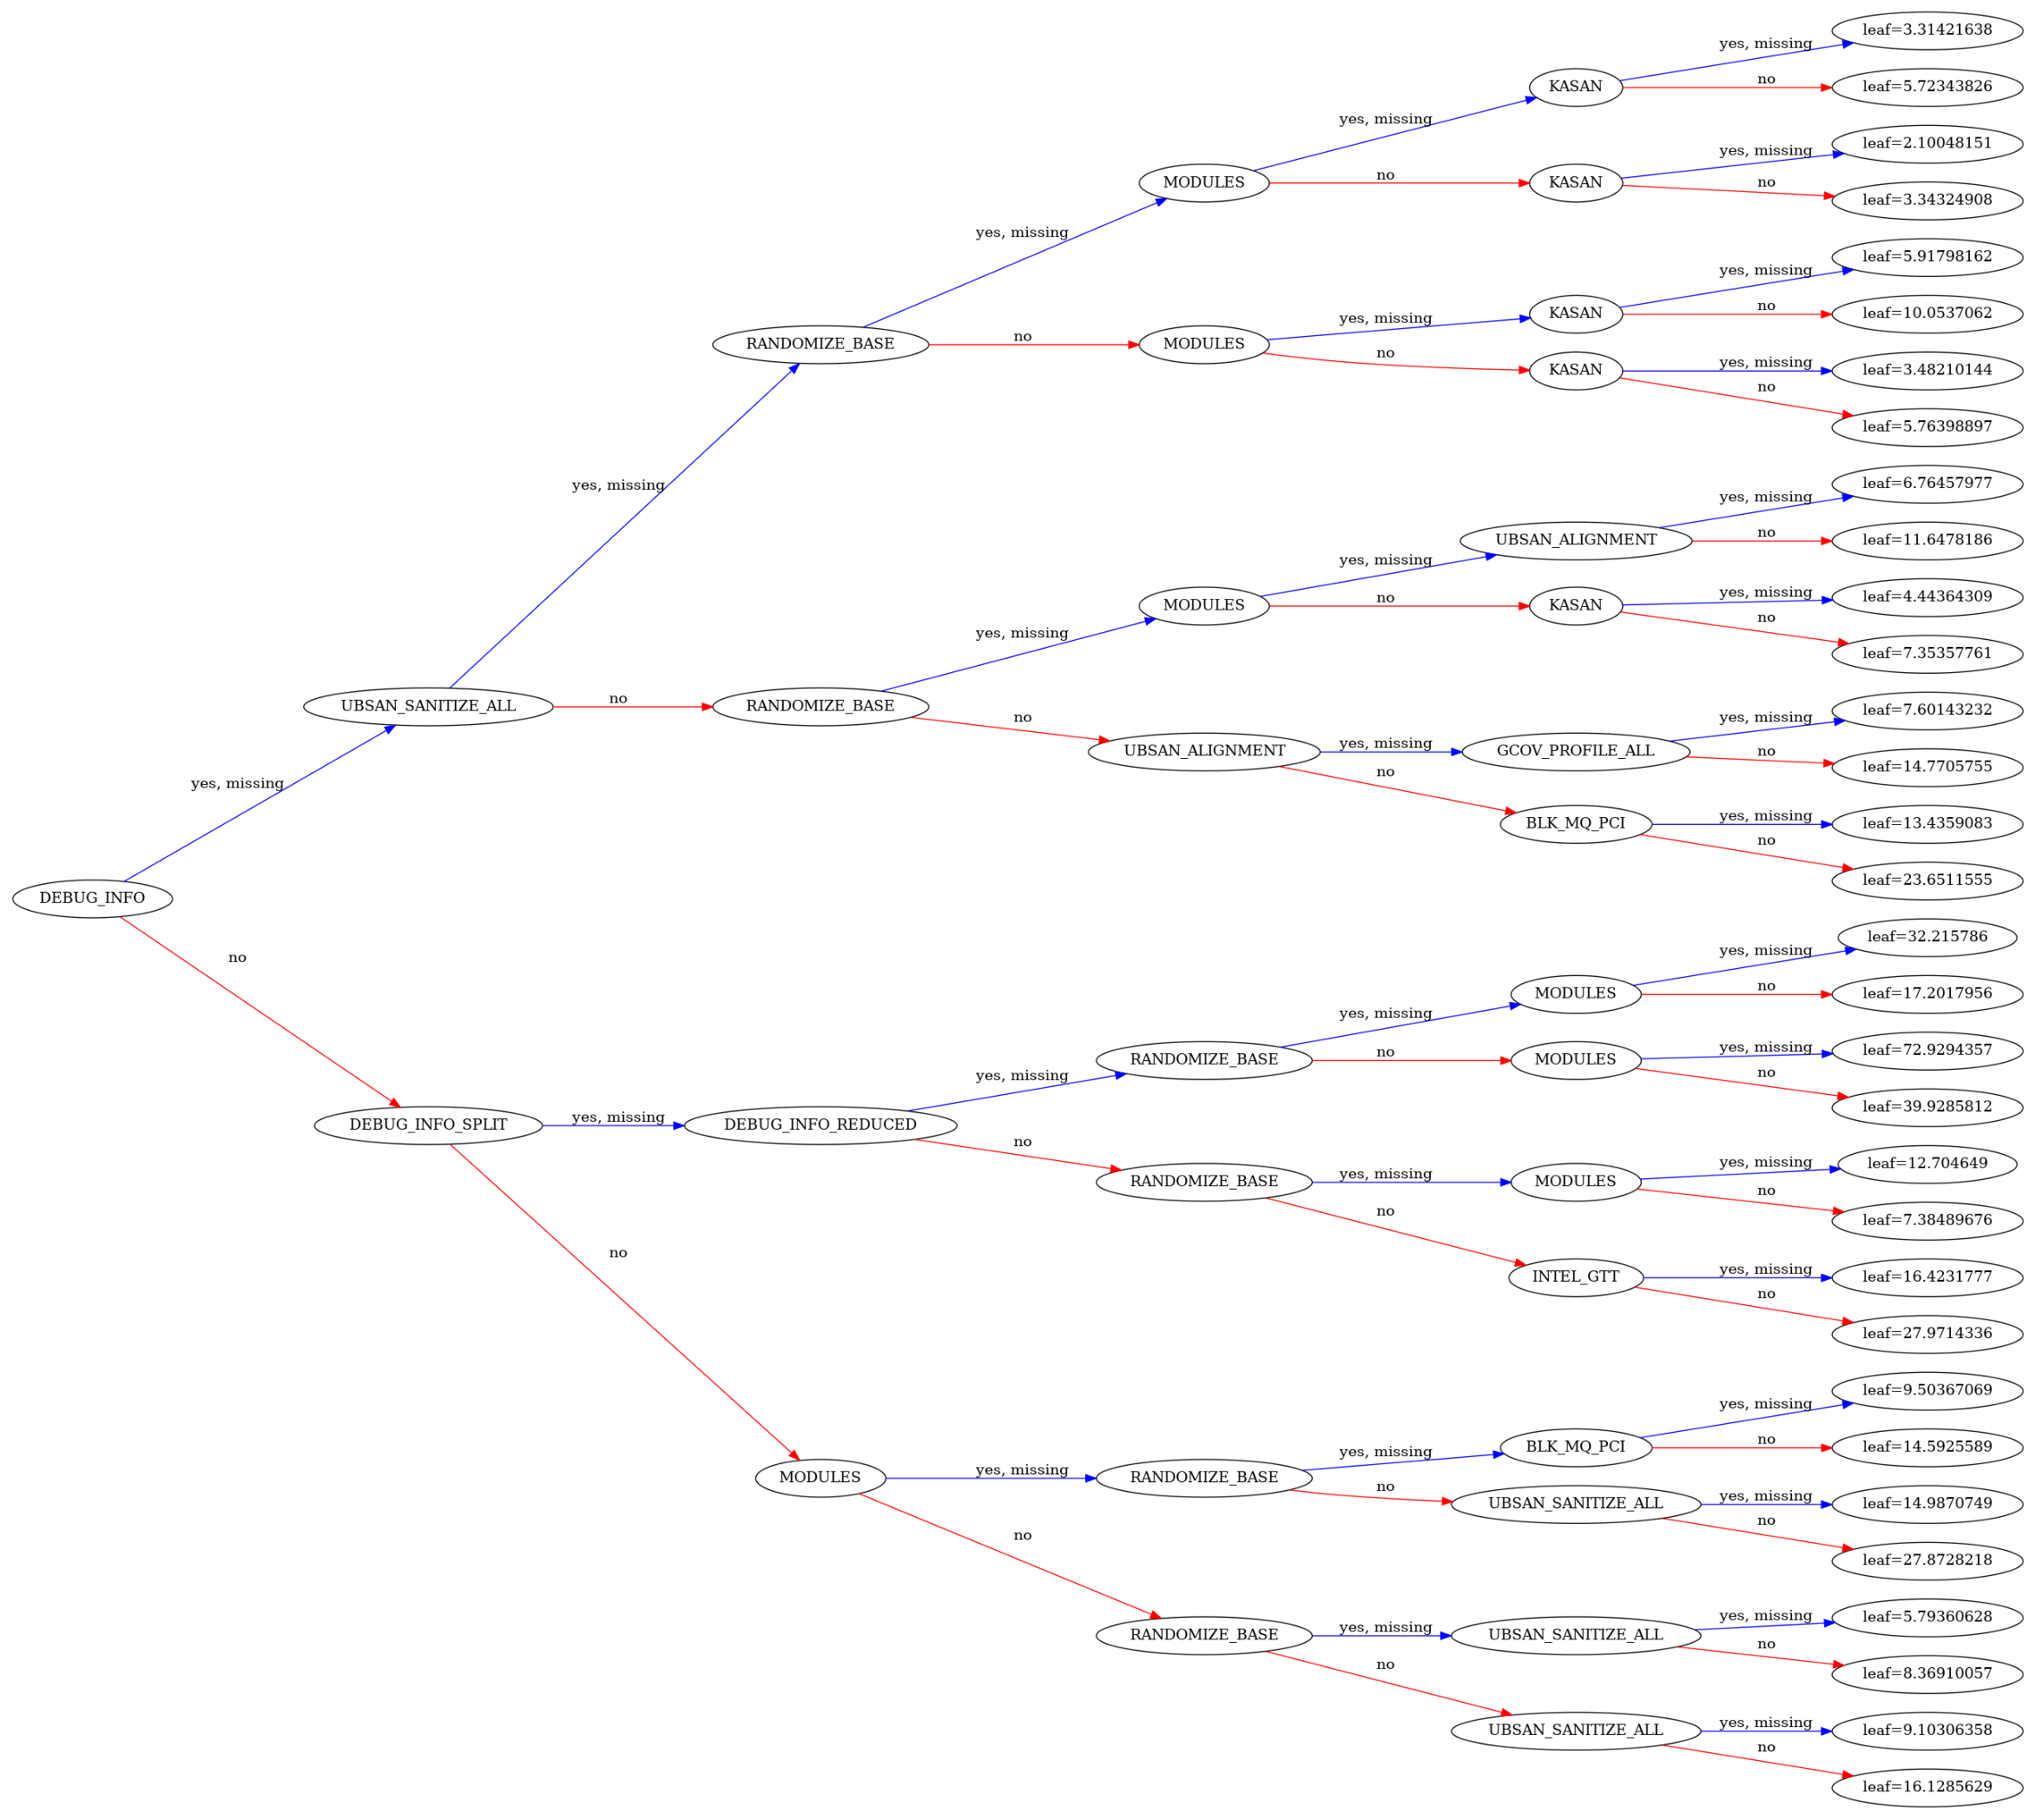

In [31]:
xgb.plot_tree(xgb_reg, num_trees=0, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(30,30)


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

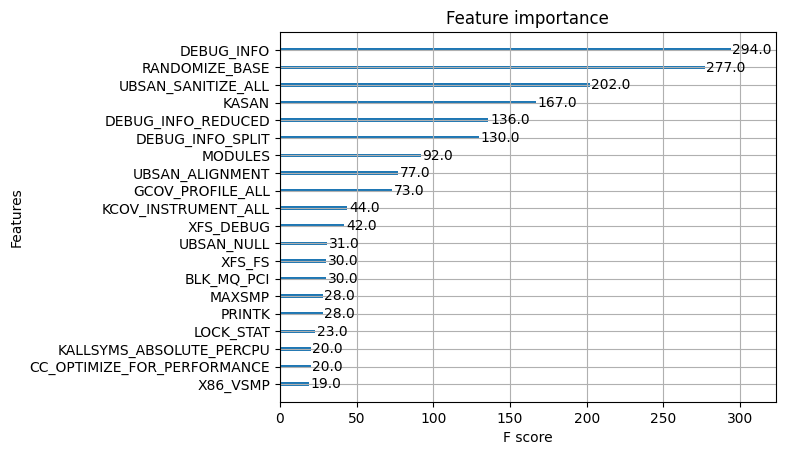

In [19]:
xgb.plot_importance(xgb_reg, max_num_features=20)

# Exp 1.b : XGBOOST, no feature selection, 4.13, HP tuning

In [2]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

X_train, y_train, X_test, y_test = tuxai_train_test_split(413)

space = {
    "eta": hp.loguniform("eta", np.log(0.001), np.log(1)),
    "max_depth": hp.randint("max_depth", 2, 20),
    "alpha": hp.uniform ('alpha', 0, 20),
    "gamma": hp.uniform ('gamma', 0, 20),
    "min_child_weight": hp.uniform ('min_child_weight', 0, 5),
    "colsample_bytree": hp.uniform('colsample_bytree', 0.5, 1),
    "max_delta_step": hp.uniform ('max_delta_step', 0, 5),
    "lambda": hp.uniform ('lambda', 0, 5),
    "n_estimators": 100,
    "eval_metric": "rmse",
    "seed": 0
}


def objective(space):
    xgb_reg = xgb.XGBRegressor(early_stopping_rounds=10, **space)    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    xgb_reg.fit(
        X_train, y_train,
        eval_set=evaluation,
        verbose=False
    )    

    y_pred = xgb_reg.predict(X_test)
    res = report(y_pred, y_test)
    print(res, space)
    print("-----")
    return {'loss': res["rmse"], 'status': STATUS_OK }
    

trials = Trials()

best_hyperparams = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

with open(data_dir / "xgboost_best_hp_1.pkl", "wb") as f:
    pickle.dump(best_hyperparams, f, protocol=pickle.HIGHEST_PROTOCOL)

best_hyperparams

{'alpha': 7.548363984447393, 'colsample_bytree': 0.9331990017392309, 'eta': 0.13763807289948127, 'eval_metric': 'rmse', 'gamma': 5.908505898456735, 'lambda': 0.691215687631403, 'max_delta_step': 2.462603404056857, 'max_depth': 9, 'min_child_weight': 2.6630229868755855, 'n_estimators': 100, 'seed': 0}
  0%|                                                                                             | 0/100 [00:00<?, ?trial/s, best loss=?]

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 70.19545054697328, 'max_error': 1346.124683380127}                                                                               
{'alpha': 7.548363984447393, 'colsample_bytree': 0.9331990017392309, 'eta': 0.13763807289948127, 'eval_metric': 'rmse', 'gamma': 5.908505898456735, 'lambda': 0.691215687631403, 'max_delta_step': 2.462603404056857, 'max_depth': 9, 'min_child_weight': 2.6630229868755855, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 18.084320761545108, 'colsample_bytree': 0.6376435574309547, 'eta': 0.8345032633135342, 'eval_metric': 'rmse', 'gamma': 2.6362264698807403, 'lambda': 4.985085094539216, 'max_delta_step': 2.201028645340983, 'max_depth': 13, 'min_child_weight': 0.10972620326032356, 'n_estimators': 100, 'seed': 0}
  1%|▋                                                                | 1/100 [03:26<5:40:57, 206.65s/trial, best l

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 46.97816926562442, 'max_error': 1196.342903137207}                                                                               
{'alpha': 18.084320761545108, 'colsample_bytree': 0.6376435574309547, 'eta': 0.8345032633135342, 'eval_metric': 'rmse', 'gamma': 2.6362264698807403, 'lambda': 4.985085094539216, 'max_delta_step': 2.201028645340983, 'max_depth': 13, 'min_child_weight': 0.10972620326032356, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 14.521489631879836, 'colsample_bytree': 0.889933863042554, 'eta': 0.0026969810560540817, 'eval_metric': 'rmse', 'gamma': 19.77626636175351, 'lambda': 0.5059157923799518, 'max_delta_step': 0.9732581874357293, 'max_depth': 3, 'min_child_weight': 2.987046537361531, 'n_estimators': 100, 'seed': 0}
  2%|█▎                                                               | 2/100 [09:13<7:52:22, 289.20s/trial, bes

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 83.61993032043779, 'max_error': 1379.7569603919983}                                                                              
{'alpha': 14.521489631879836, 'colsample_bytree': 0.889933863042554, 'eta': 0.0026969810560540817, 'eval_metric': 'rmse', 'gamma': 19.77626636175351, 'lambda': 0.5059157923799518, 'max_delta_step': 0.9732581874357293, 'max_depth': 3, 'min_child_weight': 2.987046537361531, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 4.418616362923475, 'colsample_bytree': 0.5480552925918076, 'eta': 0.030905669231709287, 'eval_metric': 'rmse', 'gamma': 16.58355294820599, 'lambda': 4.514252277777263, 'max_delta_step': 3.727020080473344, 'max_depth': 10, 'min_child_weight': 0.20977546873428288, 'n_estimators': 100, 'seed': 0}
  3%|█▉                                                               | 3/100 [11:08<5:38:53, 209.63s/trial, bes

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 77.85297360450332, 'max_error': 1368.5008478164673}                                                                              
{'alpha': 4.418616362923475, 'colsample_bytree': 0.5480552925918076, 'eta': 0.030905669231709287, 'eval_metric': 'rmse', 'gamma': 16.58355294820599, 'lambda': 4.514252277777263, 'max_delta_step': 3.727020080473344, 'max_depth': 10, 'min_child_weight': 0.20977546873428288, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 17.296010872536648, 'colsample_bytree': 0.6497889310605296, 'eta': 0.010911123465080627, 'eval_metric': 'rmse', 'gamma': 11.199104809136431, 'lambda': 0.5467194183818769, 'max_delta_step': 4.159491052972866, 'max_depth': 15, 'min_child_weight': 2.3798246823511975, 'n_estimators': 100, 'seed': 0}
  4%|██▌                                                              | 4/100 [13:08<4:38:32, 174.09s/trial, b

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 81.29383058073309, 'max_error': 1375.4809741973877}                                                                              
{'alpha': 17.296010872536648, 'colsample_bytree': 0.6497889310605296, 'eta': 0.010911123465080627, 'eval_metric': 'rmse', 'gamma': 11.199104809136431, 'lambda': 0.5467194183818769, 'max_delta_step': 4.159491052972866, 'max_depth': 15, 'min_child_weight': 2.3798246823511975, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 19.186810447821102, 'colsample_bytree': 0.8648123014526032, 'eta': 0.053786417079466395, 'eval_metric': 'rmse', 'gamma': 11.277618627653931, 'lambda': 4.617819008931784, 'max_delta_step': 3.8695641439591046, 'max_depth': 7, 'min_child_weight': 3.9975468387478923, 'n_estimators': 100, 'seed': 0}
  5%|███▎                                                             | 5/100 [14:54<3:56:55, 149.63s/trial, 

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 74.04711840948903, 'max_error': 1359.2064571380615}                                                                              
{'alpha': 19.186810447821102, 'colsample_bytree': 0.8648123014526032, 'eta': 0.053786417079466395, 'eval_metric': 'rmse', 'gamma': 11.277618627653931, 'lambda': 4.617819008931784, 'max_delta_step': 3.8695641439591046, 'max_depth': 7, 'min_child_weight': 3.9975468387478923, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 13.4359460431625, 'colsample_bytree': 0.5501831506391948, 'eta': 0.25108045865381473, 'eval_metric': 'rmse', 'gamma': 3.220695378684044, 'lambda': 0.34433649036902936, 'max_delta_step': 2.3362224007584267, 'max_depth': 10, 'min_child_weight': 2.3042682309435856, 'n_estimators': 100, 'seed': 0}
  6%|███▉                                                             | 6/100 [16:47<3:35:01, 137.25s/trial, be

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 64.32172855920386, 'max_error': 1321.361515045166}                                                                               
{'alpha': 13.4359460431625, 'colsample_bytree': 0.5501831506391948, 'eta': 0.25108045865381473, 'eval_metric': 'rmse', 'gamma': 3.220695378684044, 'lambda': 0.34433649036902936, 'max_delta_step': 2.3362224007584267, 'max_depth': 10, 'min_child_weight': 2.3042682309435856, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 4.77854029273264, 'colsample_bytree': 0.5869658938411613, 'eta': 0.32943707622781515, 'eval_metric': 'rmse', 'gamma': 8.49803696245733, 'lambda': 2.5718030034411137, 'max_delta_step': 2.290075055964386, 'max_depth': 13, 'min_child_weight': 1.8753488588188327, 'n_estimators': 100, 'seed': 0}
  7%|████▌                                                            | 7/100 [20:33<4:17:32, 166.15s/trial, best l

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 60.99604574452636, 'max_error': 1304.5758743286133}                                                                              
{'alpha': 4.77854029273264, 'colsample_bytree': 0.5869658938411613, 'eta': 0.32943707622781515, 'eval_metric': 'rmse', 'gamma': 8.49803696245733, 'lambda': 2.5718030034411137, 'max_delta_step': 2.290075055964386, 'max_depth': 13, 'min_child_weight': 1.8753488588188327, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 7.784057101701549, 'colsample_bytree': 0.5100956037589207, 'eta': 0.09686214007611561, 'eval_metric': 'rmse', 'gamma': 14.320006857115818, 'lambda': 2.605910538786405, 'max_delta_step': 2.8562728066259524, 'max_depth': 13, 'min_child_weight': 1.7750208644571808, 'n_estimators': 100, 'seed': 0}
  8%|█████▏                                                           | 8/100 [27:04<6:04:35, 237.77s/trial, best l

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 71.84647134106001, 'max_error': 1352.352975845337}                                                                               
{'alpha': 7.784057101701549, 'colsample_bytree': 0.5100956037589207, 'eta': 0.09686214007611561, 'eval_metric': 'rmse', 'gamma': 14.320006857115818, 'lambda': 2.605910538786405, 'max_delta_step': 2.8562728066259524, 'max_depth': 13, 'min_child_weight': 1.7750208644571808, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 18.861342700753536, 'colsample_bytree': 0.9915823695235775, 'eta': 0.09793677365266902, 'eval_metric': 'rmse', 'gamma': 10.232753535286106, 'lambda': 4.8961230464356955, 'max_delta_step': 0.9880830758220377, 'max_depth': 12, 'min_child_weight': 0.8010444735822131, 'n_estimators': 100, 'seed': 0}
  9%|█████▊                                                           | 9/100 [30:13<5:37:42, 222.67s/trial, b

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 78.71534157099605, 'max_error': 1370.3424835205078}                                                                              
{'alpha': 18.861342700753536, 'colsample_bytree': 0.9915823695235775, 'eta': 0.09793677365266902, 'eval_metric': 'rmse', 'gamma': 10.232753535286106, 'lambda': 4.8961230464356955, 'max_delta_step': 0.9880830758220377, 'max_depth': 12, 'min_child_weight': 0.8010444735822131, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 15.246460215603346, 'colsample_bytree': 0.8851181541439794, 'eta': 0.07261144877955217, 'eval_metric': 'rmse', 'gamma': 19.54905313811697, 'lambda': 2.8565432478244084, 'max_delta_step': 1.4133666735121135, 'max_depth': 17, 'min_child_weight': 2.7545788854497393, 'n_estimators': 100, 'seed': 0}
 10%|██████▍                                                         | 10/100 [32:36<4:56:54, 197.94s/trial, 

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 78.43723099749545, 'max_error': 1369.756775856018}                                                                               
{'alpha': 15.246460215603346, 'colsample_bytree': 0.8851181541439794, 'eta': 0.07261144877955217, 'eval_metric': 'rmse', 'gamma': 19.54905313811697, 'lambda': 2.8565432478244084, 'max_delta_step': 1.4133666735121135, 'max_depth': 17, 'min_child_weight': 2.7545788854497393, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 19.022092239063745, 'colsample_bytree': 0.7959269258414261, 'eta': 0.3954570763291632, 'eval_metric': 'rmse', 'gamma': 4.287815362733751, 'lambda': 2.497753307399356, 'max_delta_step': 4.613971117341725, 'max_depth': 14, 'min_child_weight': 3.2167433141431574, 'n_estimators': 100, 'seed': 0}
 11%|███████                                                         | 11/100 [34:34<4:17:27, 173.57s/trial, best

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 46.602307672260544, 'max_error': 1197.556495666504}                                                                              
{'alpha': 19.022092239063745, 'colsample_bytree': 0.7959269258414261, 'eta': 0.3954570763291632, 'eval_metric': 'rmse', 'gamma': 4.287815362733751, 'lambda': 2.497753307399356, 'max_delta_step': 4.613971117341725, 'max_depth': 14, 'min_child_weight': 3.2167433141431574, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 2.83020764226507, 'colsample_bytree': 0.7271705187568587, 'eta': 0.1665635836906488, 'eval_metric': 'rmse', 'gamma': 12.269108737598058, 'lambda': 3.8993867250251784, 'max_delta_step': 4.534410011020999, 'max_depth': 19, 'min_child_weight': 3.3180956704764104, 'n_estimators': 100, 'seed': 0}
 12%|███████▌                                                       | 12/100 [41:41<6:07:17, 250.43s/trial, best los

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 60.7915640778867, 'max_error': 1304.4927139282227}                                                                               
{'alpha': 2.83020764226507, 'colsample_bytree': 0.7271705187568587, 'eta': 0.1665635836906488, 'eval_metric': 'rmse', 'gamma': 12.269108737598058, 'lambda': 3.8993867250251784, 'max_delta_step': 4.534410011020999, 'max_depth': 19, 'min_child_weight': 3.3180956704764104, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 16.102268691893048, 'colsample_bytree': 0.8846273732278709, 'eta': 0.011573580823154064, 'eval_metric': 'rmse', 'gamma': 8.071622507643248, 'lambda': 3.0449784686154886, 'max_delta_step': 0.7693729609616201, 'max_depth': 11, 'min_child_weight': 1.6707385530607306, 'n_estimators': 100, 'seed': 0}
 13%|████████▏                                                      | 13/100 [49:17<7:33:38, 312.85s/trial, best

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 83.2686426114292, 'max_error': 1379.1290049552917}                                                                               
{'alpha': 16.102268691893048, 'colsample_bytree': 0.8846273732278709, 'eta': 0.011573580823154064, 'eval_metric': 'rmse', 'gamma': 8.071622507643248, 'lambda': 3.0449784686154886, 'max_delta_step': 0.7693729609616201, 'max_depth': 11, 'min_child_weight': 1.6707385530607306, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 9.324309435549793, 'colsample_bytree': 0.8222550478806456, 'eta': 0.15021505702913981, 'eval_metric': 'rmse', 'gamma': 16.277842542963782, 'lambda': 1.9533648727774149, 'max_delta_step': 4.561650019283453, 'max_depth': 10, 'min_child_weight': 3.6293348364097247, 'n_estimators': 100, 'seed': 0}
 14%|████████▊                                                      | 14/100 [51:03<5:58:42, 250.26s/trial, be

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 62.01382880822378, 'max_error': 1311.4965362548828}                                                                              
{'alpha': 9.324309435549793, 'colsample_bytree': 0.8222550478806456, 'eta': 0.15021505702913981, 'eval_metric': 'rmse', 'gamma': 16.277842542963782, 'lambda': 1.9533648727774149, 'max_delta_step': 4.561650019283453, 'max_depth': 10, 'min_child_weight': 3.6293348364097247, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 13.903841708114097, 'colsample_bytree': 0.9061702614924994, 'eta': 0.2855037366680092, 'eval_metric': 'rmse', 'gamma': 10.373048491483077, 'lambda': 3.8208000363981425, 'max_delta_step': 2.3757420579508572, 'max_depth': 13, 'min_child_weight': 2.9553752137128377, 'n_estimators': 100, 'seed': 0}
 15%|█████████▍                                                     | 15/100 [56:12<6:19:41, 268.01s/trial, bes

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 62.19064590303382, 'max_error': 1312.1910858154297}                                                                              
{'alpha': 13.903841708114097, 'colsample_bytree': 0.9061702614924994, 'eta': 0.2855037366680092, 'eval_metric': 'rmse', 'gamma': 10.373048491483077, 'lambda': 3.8208000363981425, 'max_delta_step': 2.3757420579508572, 'max_depth': 13, 'min_child_weight': 2.9553752137128377, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 15.110342846462181, 'colsample_bytree': 0.6106662112708017, 'eta': 0.006301727643271333, 'eval_metric': 'rmse', 'gamma': 7.344056933172469, 'lambda': 4.381416708368164, 'max_delta_step': 4.235904763582509, 'max_depth': 5, 'min_child_weight': 1.5928973128040287, 'n_estimators': 100, 'seed': 0}
 16%|█████████▊                                                   | 16/100 [1:02:17<6:56:21, 297.40s/trial, best

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 82.29148323988755, 'max_error': 1377.350094795227}                                                                               
{'alpha': 15.110342846462181, 'colsample_bytree': 0.6106662112708017, 'eta': 0.006301727643271333, 'eval_metric': 'rmse', 'gamma': 7.344056933172469, 'lambda': 4.381416708368164, 'max_delta_step': 4.235904763582509, 'max_depth': 5, 'min_child_weight': 1.5928973128040287, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 0.14519649515844613, 'colsample_bytree': 0.5777586386856519, 'eta': 0.15235695097374985, 'eval_metric': 'rmse', 'gamma': 17.619448438606245, 'lambda': 0.41095594976158445, 'max_delta_step': 4.944139707059334, 'max_depth': 4, 'min_child_weight': 1.1755214962219966, 'n_estimators': 100, 'seed': 0}
 17%|██████████▎                                                  | 17/100 [1:03:56<5:28:36, 237.55s/trial, bes

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 61.222617781315414, 'max_error': 1304.6920852661133}                                                                             
{'alpha': 0.14519649515844613, 'colsample_bytree': 0.5777586386856519, 'eta': 0.15235695097374985, 'eval_metric': 'rmse', 'gamma': 17.619448438606245, 'lambda': 0.41095594976158445, 'max_delta_step': 4.944139707059334, 'max_depth': 4, 'min_child_weight': 1.1755214962219966, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 3.6911619775318316, 'colsample_bytree': 0.8359193056741672, 'eta': 0.0013044857456262523, 'eval_metric': 'rmse', 'gamma': 4.0624904523816046, 'lambda': 0.5414073455999757, 'max_delta_step': 1.5474602172522645, 'max_depth': 19, 'min_child_weight': 2.622101890879898, 'n_estimators': 100, 'seed': 0}
 18%|██████████▉                                                  | 18/100 [1:06:08<4:41:17, 205.82s/trial,

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 83.65401565685062, 'max_error': 1379.8175842761993}                                                                              
{'alpha': 3.6911619775318316, 'colsample_bytree': 0.8359193056741672, 'eta': 0.0013044857456262523, 'eval_metric': 'rmse', 'gamma': 4.0624904523816046, 'lambda': 0.5414073455999757, 'max_delta_step': 1.5474602172522645, 'max_depth': 19, 'min_child_weight': 2.622101890879898, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 13.5756127166833, 'colsample_bytree': 0.9346471873280878, 'eta': 0.05119915110548125, 'eval_metric': 'rmse', 'gamma': 18.23531559969962, 'lambda': 1.9476762145624211, 'max_delta_step': 1.3394148162704562, 'max_depth': 15, 'min_child_weight': 0.1767174252639203, 'n_estimators': 100, 'seed': 0}
 19%|███████████▌                                                 | 19/100 [1:07:46<3:54:20, 173.59s/trial, be

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 80.09957833662666, 'max_error': 1373.1617631912231}                                                                              
{'alpha': 13.5756127166833, 'colsample_bytree': 0.9346471873280878, 'eta': 0.05119915110548125, 'eval_metric': 'rmse', 'gamma': 18.23531559969962, 'lambda': 1.9476762145624211, 'max_delta_step': 1.3394148162704562, 'max_depth': 15, 'min_child_weight': 0.1767174252639203, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 19.967337443552232, 'colsample_bytree': 0.7265339422382358, 'eta': 0.9501155437341935, 'eval_metric': 'rmse', 'gamma': 0.20055879910465624, 'lambda': 1.349772203187243, 'max_delta_step': 0.09680186882409503, 'max_depth': 14, 'min_child_weight': 4.510916687326497, 'n_estimators': 100, 'seed': 0}
 20%|████████████▏                                                | 20/100 [1:09:46<3:29:58, 157.48s/trial, best

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 78.94530401947894, 'max_error': 1370.822148323059}                                                                               
{'alpha': 19.967337443552232, 'colsample_bytree': 0.7265339422382358, 'eta': 0.9501155437341935, 'eval_metric': 'rmse', 'gamma': 0.20055879910465624, 'lambda': 1.349772203187243, 'max_delta_step': 0.09680186882409503, 'max_depth': 14, 'min_child_weight': 4.510916687326497, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 11.58508131029742, 'colsample_bytree': 0.775038475945692, 'eta': 0.9565150838373551, 'eval_metric': 'rmse', 'gamma': 0.13984627817718476, 'lambda': 3.4052424526104703, 'max_delta_step': 3.386510853836946, 'max_depth': 14, 'min_child_weight': 4.860636922356802, 'n_estimators': 100, 'seed': 0}
 21%|████████████▊                                                | 21/100 [1:11:31<3:06:28, 141.63s/trial, best 

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 36.293900221559696, 'max_error': 1056.094581604004}                                                                              
{'alpha': 11.58508131029742, 'colsample_bytree': 0.775038475945692, 'eta': 0.9565150838373551, 'eval_metric': 'rmse', 'gamma': 0.13984627817718476, 'lambda': 3.4052424526104703, 'max_delta_step': 3.386510853836946, 'max_depth': 14, 'min_child_weight': 4.860636922356802, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 11.526257002588245, 'colsample_bytree': 0.7833392088236963, 'eta': 0.5238192283411884, 'eval_metric': 'rmse', 'gamma': 0.8228089844774127, 'lambda': 3.2511144178108027, 'max_delta_step': 3.333525883485012, 'max_depth': 14, 'min_child_weight': 4.660444255916549, 'n_estimators': 100, 'seed': 0}
 22%|█████████████▍                                               | 22/100 [1:18:39<4:56:00, 227.70s/trial, best lo

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 47.50707567452546, 'max_error': 1205.4029006958008}                                                                              
{'alpha': 11.526257002588245, 'colsample_bytree': 0.7833392088236963, 'eta': 0.5238192283411884, 'eval_metric': 'rmse', 'gamma': 0.8228089844774127, 'lambda': 3.2511144178108027, 'max_delta_step': 3.333525883485012, 'max_depth': 14, 'min_child_weight': 4.660444255916549, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 11.532144886127327, 'colsample_bytree': 0.6838879410915826, 'eta': 0.5804139042249743, 'eval_metric': 'rmse', 'gamma': 1.7375600336903627, 'lambda': 3.4302574676382895, 'max_delta_step': 3.0676995457335274, 'max_depth': 6, 'min_child_weight': 4.955920728147822, 'n_estimators': 100, 'seed': 0}
 23%|██████████████                                               | 23/100 [1:25:33<6:03:45, 283.44s/trial, best l

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 47.063645871356556, 'max_error': 1201.9660568237305}                                                                             
{'alpha': 11.532144886127327, 'colsample_bytree': 0.6838879410915826, 'eta': 0.5804139042249743, 'eval_metric': 'rmse', 'gamma': 1.7375600336903627, 'lambda': 3.4302574676382895, 'max_delta_step': 3.0676995457335274, 'max_depth': 6, 'min_child_weight': 4.955920728147822, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 11.374376366615824, 'colsample_bytree': 0.7728205263843998, 'eta': 0.517828940303913, 'eval_metric': 'rmse', 'gamma': 4.745575366202144, 'lambda': 1.881060522389022, 'max_delta_step': 4.9705783876333935, 'max_depth': 16, 'min_child_weight': 4.127897595584861, 'n_estimators': 100, 'seed': 0}
 24%|██████████████▋                                              | 24/100 [1:28:34<5:20:22, 252.92s/trial, best los

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 40.421278952420046, 'max_error': 1122.6283950805664}                                                                             
{'alpha': 11.374376366615824, 'colsample_bytree': 0.7728205263843998, 'eta': 0.517828940303913, 'eval_metric': 'rmse', 'gamma': 4.745575366202144, 'lambda': 1.881060522389022, 'max_delta_step': 4.9705783876333935, 'max_depth': 16, 'min_child_weight': 4.127897595584861, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 11.301956824522726, 'colsample_bytree': 0.7640741169261339, 'eta': 0.9748558271099925, 'eval_metric': 'rmse', 'gamma': 5.839385208699508, 'lambda': 1.4350255905929585, 'max_delta_step': 4.997979625039049, 'max_depth': 16, 'min_child_weight': 4.130345744681071, 'n_estimators': 100, 'seed': 0}
 25%|███████████████▎                                             | 25/100 [1:36:37<6:42:23, 321.92s/trial, best loss

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 29.644496925534845, 'max_error': 897.6604690551758}                                                                              
{'alpha': 11.301956824522726, 'colsample_bytree': 0.7640741169261339, 'eta': 0.9748558271099925, 'eval_metric': 'rmse', 'gamma': 5.839385208699508, 'lambda': 1.4350255905929585, 'max_delta_step': 4.997979625039049, 'max_depth': 16, 'min_child_weight': 4.130345744681071, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 9.38710775291625, 'colsample_bytree': 0.72264960051346, 'eta': 0.8833431110504403, 'eval_metric': 'rmse', 'gamma': 6.690133555190703, 'lambda': 1.0619993258928695, 'max_delta_step': 3.5767509023185626, 'max_depth': 18, 'min_child_weight': 4.872712746352706, 'n_estimators': 100, 'seed': 0}
 26%|███████████████▊                                             | 26/100 [1:44:48<7:39:19, 372.42s/trial, best loss: 

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 37.13221730904258, 'max_error': 1064.0697708129883}                                                                              
{'alpha': 9.38710775291625, 'colsample_bytree': 0.72264960051346, 'eta': 0.8833431110504403, 'eval_metric': 'rmse', 'gamma': 6.690133555190703, 'lambda': 1.0619993258928695, 'max_delta_step': 3.5767509023185626, 'max_depth': 18, 'min_child_weight': 4.872712746352706, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 6.673198459700996, 'colsample_bytree': 0.6911093595357122, 'eta': 0.9357107785334757, 'eval_metric': 'rmse', 'gamma': 0.2064275210474138, 'lambda': 0.03687663909960737, 'max_delta_step': 2.8853199434995664, 'max_depth': 2, 'min_child_weight': 4.226332989569775, 'n_estimators': 100, 'seed': 0}
 27%|████████████████▍                                            | 27/100 [1:53:29<8:27:21, 417.01s/trial, best loss:

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 42.98439894210429, 'max_error': 1110.0368118286133}                                                                              
{'alpha': 6.673198459700996, 'colsample_bytree': 0.6911093595357122, 'eta': 0.9357107785334757, 'eval_metric': 'rmse', 'gamma': 0.2064275210474138, 'lambda': 0.03687663909960737, 'max_delta_step': 2.8853199434995664, 'max_depth': 2, 'min_child_weight': 4.226332989569775, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 6.679669508817132, 'colsample_bytree': 0.9448953636324079, 'eta': 0.024180487716260024, 'eval_metric': 'rmse', 'gamma': 5.745519758734345, 'lambda': 1.4495474446255425, 'max_delta_step': 1.8865004947483301, 'max_depth': 8, 'min_child_weight': 3.832727219417132, 'n_estimators': 100, 'seed': 0}
 28%|█████████████████                                            | 28/100 [1:55:11<6:27:11, 322.65s/trial, best l

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 81.28164765860959, 'max_error': 1375.4577989578247}                                                                              
{'alpha': 6.679669508817132, 'colsample_bytree': 0.9448953636324079, 'eta': 0.024180487716260024, 'eval_metric': 'rmse', 'gamma': 5.745519758734345, 'lambda': 1.4495474446255425, 'max_delta_step': 1.8865004947483301, 'max_depth': 8, 'min_child_weight': 3.832727219417132, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 12.462075625343335, 'colsample_bytree': 0.8364361969223248, 'eta': 0.20935522362788944, 'eval_metric': 'rmse', 'gamma': 1.9463166542628587, 'lambda': 2.1929851988872477, 'max_delta_step': 3.3502543941070706, 'max_depth': 16, 'min_child_weight': 4.463809105716923, 'n_estimators': 100, 'seed': 0}
 29%|█████████████████▋                                           | 29/100 [1:56:40<4:58:54, 252.60s/trial, best

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 61.71559779788009, 'max_error': 1309.880126953125}                                                                               
{'alpha': 12.462075625343335, 'colsample_bytree': 0.8364361969223248, 'eta': 0.20935522362788944, 'eval_metric': 'rmse', 'gamma': 1.9463166542628587, 'lambda': 2.1929851988872477, 'max_delta_step': 3.3502543941070706, 'max_depth': 16, 'min_child_weight': 4.463809105716923, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 10.41501864694087, 'colsample_bytree': 0.7563904763869029, 'eta': 0.6402459776901674, 'eval_metric': 'rmse', 'gamma': 5.645309888520187, 'lambda': 1.0738404995454864, 'max_delta_step': 4.033190700786713, 'max_depth': 9, 'min_child_weight': 3.6021613564168278, 'n_estimators': 100, 'seed': 0}
 30%|██████████████████▎                                          | 30/100 [2:03:30<5:49:39, 299.71s/trial, best l

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 40.03404753676527, 'max_error': 1121.7961807250977}                                                                              
{'alpha': 10.41501864694087, 'colsample_bytree': 0.7563904763869029, 'eta': 0.6402459776901674, 'eval_metric': 'rmse', 'gamma': 5.645309888520187, 'lambda': 1.0738404995454864, 'max_delta_step': 4.033190700786713, 'max_depth': 9, 'min_child_weight': 3.6021613564168278, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 7.930619150394022, 'colsample_bytree': 0.9786169688569558, 'eta': 0.0013170327052421894, 'eval_metric': 'rmse', 'gamma': 13.341079712783834, 'lambda': 3.884696293249128, 'max_delta_step': 0.017504877803421692, 'max_depth': 3, 'min_child_weight': 4.914148046773756, 'n_estimators': 100, 'seed': 0}
 31%|██████████████████▉                                          | 31/100 [2:08:04<5:35:59, 292.17s/trial, best 

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 83.76642670310416, 'max_error': 1380.0171406269073}                                                                              
{'alpha': 7.930619150394022, 'colsample_bytree': 0.9786169688569558, 'eta': 0.0013170327052421894, 'eval_metric': 'rmse', 'gamma': 13.341079712783834, 'lambda': 3.884696293249128, 'max_delta_step': 0.017504877803421692, 'max_depth': 3, 'min_child_weight': 4.914148046773756, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 16.450374508319662, 'colsample_bytree': 0.6700584216852229, 'eta': 0.0035794813606002496, 'eval_metric': 'rmse', 'gamma': 9.126192567431668, 'lambda': 3.567146919797807, 'max_delta_step': 1.8680607340056867, 'max_depth': 16, 'min_child_weight': 4.307985600024522, 'n_estimators': 100, 'seed': 0}
 32%|███████████████████▌                                         | 32/100 [2:10:17<4:36:44, 244.18s/trial, b

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 83.39233503249024, 'max_error': 1379.350778579712}                                                                               
{'alpha': 16.450374508319662, 'colsample_bytree': 0.6700584216852229, 'eta': 0.0035794813606002496, 'eval_metric': 'rmse', 'gamma': 9.126192567431668, 'lambda': 3.567146919797807, 'max_delta_step': 1.8680607340056867, 'max_depth': 16, 'min_child_weight': 4.307985600024522, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 10.11995467403009, 'colsample_bytree': 0.8132719806844708, 'eta': 0.016605155780801045, 'eval_metric': 'rmse', 'gamma': 2.906662408319313, 'lambda': 1.5200241756467006, 'max_delta_step': 2.6348095756444074, 'max_depth': 8, 'min_child_weight': 4.997927140405824, 'n_estimators': 100, 'seed': 0}
 33%|████████████████████▏                                        | 33/100 [2:11:37<3:37:40, 194.94s/trial, best

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 81.37976854340663, 'max_error': 1375.644305229187}                                                                               
{'alpha': 10.11995467403009, 'colsample_bytree': 0.8132719806844708, 'eta': 0.016605155780801045, 'eval_metric': 'rmse', 'gamma': 2.906662408319313, 'lambda': 1.5200241756467006, 'max_delta_step': 2.6348095756444074, 'max_depth': 8, 'min_child_weight': 4.997927140405824, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 0.4260690079034628, 'colsample_bytree': 0.6421574205107033, 'eta': 0.04174877550429818, 'eval_metric': 'rmse', 'gamma': 1.7944068707048484, 'lambda': 2.337469345399382, 'max_delta_step': 4.788444577879269, 'max_depth': 7, 'min_child_weight': 3.8091983049260763, 'n_estimators': 100, 'seed': 0}
 34%|████████████████████▋                                        | 34/100 [2:13:02<2:58:08, 161.94s/trial, best l

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 74.34493053534835, 'max_error': 1360.02827835083}                                                                                
{'alpha': 0.4260690079034628, 'colsample_bytree': 0.6421574205107033, 'eta': 0.04174877550429818, 'eval_metric': 'rmse', 'gamma': 1.7944068707048484, 'lambda': 2.337469345399382, 'max_delta_step': 4.788444577879269, 'max_depth': 7, 'min_child_weight': 3.8091983049260763, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 12.83678499728788, 'colsample_bytree': 0.8607784822860347, 'eta': 0.41872433826332506, 'eval_metric': 'rmse', 'gamma': 6.803615124822931, 'lambda': 0.8586294615765881, 'max_delta_step': 3.58801203515887, 'max_depth': 5, 'min_child_weight': 3.3418806648945787, 'n_estimators': 100, 'seed': 0}
 35%|█████████████████████▎                                       | 35/100 [2:14:34<2:32:55, 141.17s/trial, best los

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 50.111766294819084, 'max_error': 1229.7807693481445}                                                                             
{'alpha': 12.83678499728788, 'colsample_bytree': 0.8607784822860347, 'eta': 0.41872433826332506, 'eval_metric': 'rmse', 'gamma': 6.803615124822931, 'lambda': 0.8586294615765881, 'max_delta_step': 3.58801203515887, 'max_depth': 5, 'min_child_weight': 3.3418806648945787, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 5.487220735659349, 'colsample_bytree': 0.7591018549947032, 'eta': 0.10168331031229055, 'eval_metric': 'rmse', 'gamma': 3.5895639659565846, 'lambda': 4.22659265848557, 'max_delta_step': 4.244355718372487, 'max_depth': 14, 'min_child_weight': 4.708055712568429, 'n_estimators': 100, 'seed': 0}
 36%|█████████████████████▉                                       | 36/100 [2:17:43<2:45:43, 155.36s/trial, best loss:

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 67.56445701488609, 'max_error': 1336.8614616394043}                                                                              
{'alpha': 5.487220735659349, 'colsample_bytree': 0.7591018549947032, 'eta': 0.10168331031229055, 'eval_metric': 'rmse', 'gamma': 3.5895639659565846, 'lambda': 4.22659265848557, 'max_delta_step': 4.244355718372487, 'max_depth': 14, 'min_child_weight': 4.708055712568429, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 8.482703695760053, 'colsample_bytree': 0.7002698978465878, 'eta': 0.7196577854865311, 'eval_metric': 'rmse', 'gamma': 5.130474273864799, 'lambda': 2.9574333298894055, 'max_delta_step': 3.8871073123754747, 'max_depth': 2, 'min_child_weight': 2.259208809907199, 'n_estimators': 100, 'seed': 0}
 37%|██████████████████████▌                                      | 37/100 [2:22:06<3:16:57, 187.58s/trial, best loss:

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 42.55323861764644, 'max_error': 1100.280403137207}                                                                               
{'alpha': 8.482703695760053, 'colsample_bytree': 0.7002698978465878, 'eta': 0.7196577854865311, 'eval_metric': 'rmse', 'gamma': 5.130474273864799, 'lambda': 2.9574333298894055, 'max_delta_step': 3.8871073123754747, 'max_depth': 2, 'min_child_weight': 2.259208809907199, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 17.119382793262005, 'colsample_bytree': 0.5119997980297266, 'eta': 0.25069760620835807, 'eval_metric': 'rmse', 'gamma': 0.9226665118115207, 'lambda': 0.039818054908201006, 'max_delta_step': 3.3124726687472164, 'max_depth': 12, 'min_child_weight': 3.9397857001426835, 'n_estimators': 100, 'seed': 0}
 38%|███████████████████████▏                                     | 38/100 [2:23:49<2:47:42, 162.29s/trial, bes

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 59.76548088512152, 'max_error': 1296.976547241211}                                                                               
{'alpha': 17.119382793262005, 'colsample_bytree': 0.5119997980297266, 'eta': 0.25069760620835807, 'eval_metric': 'rmse', 'gamma': 0.9226665118115207, 'lambda': 0.039818054908201006, 'max_delta_step': 3.3124726687472164, 'max_depth': 12, 'min_child_weight': 3.9397857001426835, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 2.09089059863245, 'colsample_bytree': 0.8562386156381357, 'eta': 0.005748050799185476, 'eval_metric': 'rmse', 'gamma': 9.350310135104127, 'lambda': 4.905890851995367, 'max_delta_step': 0.5341030352999798, 'max_depth': 17, 'min_child_weight': 0.6091722601052747, 'n_estimators': 100, 'seed': 0}
 39%|███████████████████████▊                                     | 39/100 [2:27:39<3:05:37, 182.59s/trial, b

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 83.5949191478042, 'max_error': 1379.7124416828156}                                                                               
{'alpha': 2.09089059863245, 'colsample_bytree': 0.8562386156381357, 'eta': 0.005748050799185476, 'eval_metric': 'rmse', 'gamma': 9.350310135104127, 'lambda': 4.905890851995367, 'max_delta_step': 0.5341030352999798, 'max_depth': 17, 'min_child_weight': 0.6091722601052747, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 6.2516974485202645, 'colsample_bytree': 0.627404007232556, 'eta': 0.027820471707554577, 'eval_metric': 'rmse', 'gamma': 7.748310613702997, 'lambda': 1.6835902714047752, 'max_delta_step': 2.821177257451509, 'max_depth': 16, 'min_child_weight': 3.0366890044382533, 'n_estimators': 100, 'seed': 0}
 40%|████████████████████████▍                                    | 40/100 [2:29:04<2:33:23, 153.39s/trial, best 

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 79.60424122474159, 'max_error': 1372.170802116394}                                                                               
{'alpha': 6.2516974485202645, 'colsample_bytree': 0.627404007232556, 'eta': 0.027820471707554577, 'eval_metric': 'rmse', 'gamma': 7.748310613702997, 'lambda': 1.6835902714047752, 'max_delta_step': 2.821177257451509, 'max_depth': 16, 'min_child_weight': 3.0366890044382533, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 14.504749471842619, 'colsample_bytree': 0.800168620175758, 'eta': 0.07906227266633978, 'eval_metric': 'rmse', 'gamma': 15.05831286632835, 'lambda': 2.798914296192636, 'max_delta_step': 4.290545883994899, 'max_depth': 6, 'min_child_weight': 3.4958138273761166, 'n_estimators': 100, 'seed': 0}
 41%|█████████████████████████                                    | 41/100 [2:30:23<2:08:54, 131.10s/trial, best lo

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 70.14027048715032, 'max_error': 1346.0974197387695}                                                                              
{'alpha': 14.504749471842619, 'colsample_bytree': 0.800168620175758, 'eta': 0.07906227266633978, 'eval_metric': 'rmse', 'gamma': 15.05831286632835, 'lambda': 2.798914296192636, 'max_delta_step': 4.290545883994899, 'max_depth': 6, 'min_child_weight': 3.4958138273761166, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 12.457366833733648, 'colsample_bytree': 0.6663466790100969, 'eta': 0.3280384714927699, 'eval_metric': 'rmse', 'gamma': 12.114756769384005, 'lambda': 2.1777222251944135, 'max_delta_step': 2.1366023322222376, 'max_depth': 11, 'min_child_weight': 2.0119399522650436, 'n_estimators': 100, 'seed': 0}
 42%|█████████████████████████▌                                   | 42/100 [2:32:48<2:10:42, 135.22s/trial, best l

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 61.87824076868972, 'max_error': 1309.9305725097656}                                                                              
{'alpha': 12.457366833733648, 'colsample_bytree': 0.6663466790100969, 'eta': 0.3280384714927699, 'eval_metric': 'rmse', 'gamma': 12.114756769384005, 'lambda': 2.1777222251944135, 'max_delta_step': 2.1366023322222376, 'max_depth': 11, 'min_child_weight': 2.0119399522650436, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 8.853889112553315, 'colsample_bytree': 0.9063724798776268, 'eta': 0.20941546536063077, 'eval_metric': 'rmse', 'gamma': 2.3622945963570015, 'lambda': 4.116415957598489, 'max_delta_step': 3.732894638474435, 'max_depth': 18, 'min_child_weight': 4.4379950443573755, 'n_estimators': 100, 'seed': 0}
 43%|██████████████████████████▏                                  | 43/100 [2:36:52<2:39:22, 167.76s/trial, best

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 60.28419328977098, 'max_error': 1301.8468551635742}                                                                              
{'alpha': 8.853889112553315, 'colsample_bytree': 0.9063724798776268, 'eta': 0.20941546536063077, 'eval_metric': 'rmse', 'gamma': 2.3622945963570015, 'lambda': 4.116415957598489, 'max_delta_step': 3.732894638474435, 'max_depth': 18, 'min_child_weight': 4.4379950443573755, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 17.909955819232017, 'colsample_bytree': 0.7111166129627879, 'eta': 0.4001522043954574, 'eval_metric': 'rmse', 'gamma': 11.17341069619579, 'lambda': 3.2203155559398877, 'max_delta_step': 3.116460264600276, 'max_depth': 4, 'min_child_weight': 4.080016205386217, 'n_estimators': 100, 'seed': 0}
 44%|██████████████████████████▊                                  | 44/100 [2:45:27<4:13:45, 271.88s/trial, best los

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 53.80807270075511, 'max_error': 1255.3137512207031}                                                                              
{'alpha': 17.909955819232017, 'colsample_bytree': 0.7111166129627879, 'eta': 0.4001522043954574, 'eval_metric': 'rmse', 'gamma': 11.17341069619579, 'lambda': 3.2203155559398877, 'max_delta_step': 3.116460264600276, 'max_depth': 4, 'min_child_weight': 4.080016205386217, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 10.75128252509718, 'colsample_bytree': 0.741733848534426, 'eta': 0.9491600976836707, 'eval_metric': 'rmse', 'gamma': 6.740926183331705, 'lambda': 2.6067580107021255, 'max_delta_step': 4.508748638846701, 'max_depth': 9, 'min_child_weight': 1.3931002200983125, 'n_estimators': 100, 'seed': 0}
 45%|███████████████████████████▍                                 | 45/100 [2:47:49<3:33:44, 233.17s/trial, best loss: 

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 30.71006949096578, 'max_error': 952.067512512207}                                                                                
{'alpha': 10.75128252509718, 'colsample_bytree': 0.741733848534426, 'eta': 0.9491600976836707, 'eval_metric': 'rmse', 'gamma': 6.740926183331705, 'lambda': 2.6067580107021255, 'max_delta_step': 4.508748638846701, 'max_depth': 9, 'min_child_weight': 1.3931002200983125, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 10.571926870088529, 'colsample_bytree': 0.7382886448752918, 'eta': 0.11907313162913512, 'eval_metric': 'rmse', 'gamma': 8.806290986228237, 'lambda': 1.252100490656245, 'max_delta_step': 4.714239060381056, 'max_depth': 9, 'min_child_weight': 1.4249697471650191, 'n_estimators': 100, 'seed': 0}
 46%|████████████████████████████                                 | 46/100 [2:52:30<3:42:40, 247.43s/trial, best loss:

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 64.57138040877577, 'max_error': 1323.885498046875}                                                                               
{'alpha': 10.571926870088529, 'colsample_bytree': 0.7382886448752918, 'eta': 0.11907313162913512, 'eval_metric': 'rmse', 'gamma': 8.806290986228237, 'lambda': 1.252100490656245, 'max_delta_step': 4.714239060381056, 'max_depth': 9, 'min_child_weight': 1.4249697471650191, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 7.558904578429262, 'colsample_bytree': 0.9682686069045497, 'eta': 0.0020746806722640883, 'eval_metric': 'rmse', 'gamma': 6.892164236470431, 'lambda': 2.7197719824743745, 'max_delta_step': 4.906848499948753, 'max_depth': 3, 'min_child_weight': 0.5675085767898618, 'n_estimators': 100, 'seed': 0}
 47%|████████████████████████████▋                                | 47/100 [2:56:21<3:34:07, 242.41s/trial, best l

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 83.19773593461443, 'max_error': 1379.0014357566833}                                                                              
{'alpha': 7.558904578429262, 'colsample_bytree': 0.9682686069045497, 'eta': 0.0020746806722640883, 'eval_metric': 'rmse', 'gamma': 6.892164236470431, 'lambda': 2.7197719824743745, 'max_delta_step': 4.906848499948753, 'max_depth': 3, 'min_child_weight': 0.5675085767898618, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 15.99987893673618, 'colsample_bytree': 0.5591461905030632, 'eta': 0.06630038486247272, 'eval_metric': 'rmse', 'gamma': 10.097509166670983, 'lambda': 0.7308405696612149, 'max_delta_step': 4.429583960105006, 'max_depth': 9, 'min_child_weight': 1.1846609080302155, 'n_estimators': 100, 'seed': 0}
 48%|█████████████████████████████▎                               | 48/100 [2:58:23<2:58:45, 206.25s/trial, best 

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 71.37830175648004, 'max_error': 1350.6510963439941}                                                                              
{'alpha': 15.99987893673618, 'colsample_bytree': 0.5591461905030632, 'eta': 0.06630038486247272, 'eval_metric': 'rmse', 'gamma': 10.097509166670983, 'lambda': 0.7308405696612149, 'max_delta_step': 4.429583960105006, 'max_depth': 9, 'min_child_weight': 1.1846609080302155, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 4.92992262771274, 'colsample_bytree': 0.5856075519170096, 'eta': 0.017956240130015313, 'eval_metric': 'rmse', 'gamma': 12.913437616063248, 'lambda': 0.2402051205938478, 'max_delta_step': 4.44839488900353, 'max_depth': 15, 'min_child_weight': 2.1848347561572337, 'n_estimators': 100, 'seed': 0}
 49%|█████████████████████████████▉                               | 49/100 [3:00:50<2:40:14, 188.51s/trial, best l

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 79.5355272354852, 'max_error': 1372.0318021774292}                                                                               
{'alpha': 4.92992262771274, 'colsample_bytree': 0.5856075519170096, 'eta': 0.017956240130015313, 'eval_metric': 'rmse', 'gamma': 12.913437616063248, 'lambda': 0.2402051205938478, 'max_delta_step': 4.44839488900353, 'max_depth': 15, 'min_child_weight': 2.1848347561572337, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 1.4159117251568922, 'colsample_bytree': 0.6082708585521136, 'eta': 0.19012168133950044, 'eval_metric': 'rmse', 'gamma': 6.159293707162624, 'lambda': 2.4550937581062056, 'max_delta_step': 4.009763268184888, 'max_depth': 9, 'min_child_weight': 2.5230388175816296, 'n_estimators': 100, 'seed': 0}
 50%|██████████████████████████████▌                              | 50/100 [3:02:23<2:13:14, 159.89s/trial, best l

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 60.765350476857286, 'max_error': 1303.7850875854492}                                                                             
{'alpha': 1.4159117251568922, 'colsample_bytree': 0.6082708585521136, 'eta': 0.19012168133950044, 'eval_metric': 'rmse', 'gamma': 6.159293707162624, 'lambda': 2.4550937581062056, 'max_delta_step': 4.009763268184888, 'max_depth': 9, 'min_child_weight': 2.5230388175816296, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 3.8948355674959876, 'colsample_bytree': 0.5324159544451228, 'eta': 0.00884689793344917, 'eval_metric': 'rmse', 'gamma': 11.079791607934618, 'lambda': 1.658847199857194, 'max_delta_step': 4.754527484422748, 'max_depth': 10, 'min_child_weight': 0.39901337360488043, 'n_estimators': 100, 'seed': 0}
 51%|███████████████████████████████                              | 51/100 [3:05:48<2:21:36, 173.40s/trial, best

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 81.46904745426487, 'max_error': 1375.8131704330444}                                                                              
{'alpha': 3.8948355674959876, 'colsample_bytree': 0.5324159544451228, 'eta': 0.00884689793344917, 'eval_metric': 'rmse', 'gamma': 11.079791607934618, 'lambda': 1.658847199857194, 'max_delta_step': 4.754527484422748, 'max_depth': 10, 'min_child_weight': 0.39901337360488043, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 14.179630713087423, 'colsample_bytree': 0.7434462549137062, 'eta': 0.04389291506510339, 'eval_metric': 'rmse', 'gamma': 3.5195376405163055, 'lambda': 2.1176271851740984, 'max_delta_step': 4.088972637104646, 'max_depth': 7, 'min_child_weight': 0.970909440973712, 'n_estimators': 100, 'seed': 0}
 52%|███████████████████████████████▋                             | 52/100 [3:07:21<1:59:21, 149.19s/trial, best

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 75.11944907461586, 'max_error': 1362.071756362915}                                                                               
{'alpha': 14.179630713087423, 'colsample_bytree': 0.7434462549137062, 'eta': 0.04389291506510339, 'eval_metric': 'rmse', 'gamma': 3.5195376405163055, 'lambda': 2.1176271851740984, 'max_delta_step': 4.088972637104646, 'max_depth': 7, 'min_child_weight': 0.970909440973712, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 15.255057229799071, 'colsample_bytree': 0.6557545326011204, 'eta': 0.7297715892747193, 'eval_metric': 'rmse', 'gamma': 14.757574154814968, 'lambda': 1.768608892497887, 'max_delta_step': 4.423033194886553, 'max_depth': 12, 'min_child_weight': 2.7360564163063086, 'n_estimators': 100, 'seed': 0}
 53%|████████████████████████████████▎                            | 53/100 [3:09:39<1:54:20, 145.97s/trial, best l

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 36.66542833153071, 'max_error': 1057.2390213012695}                                                                              
{'alpha': 15.255057229799071, 'colsample_bytree': 0.6557545326011204, 'eta': 0.7297715892747193, 'eval_metric': 'rmse', 'gamma': 14.757574154814968, 'lambda': 1.768608892497887, 'max_delta_step': 4.423033194886553, 'max_depth': 12, 'min_child_weight': 2.7360564163063086, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 13.409808023829282, 'colsample_bytree': 0.9068379286192254, 'eta': 0.12285290767255293, 'eval_metric': 'rmse', 'gamma': 8.410777897338596, 'lambda': 4.5972434128874085, 'max_delta_step': 4.966126118763945, 'max_depth': 19, 'min_child_weight': 0.01923031692720234, 'n_estimators': 100, 'seed': 0}
 54%|████████████████████████████████▉                            | 54/100 [3:14:58<2:31:44, 197.92s/trial, best

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 63.50112070809299, 'max_error': 1319.009105682373}                                                                               
{'alpha': 13.409808023829282, 'colsample_bytree': 0.9068379286192254, 'eta': 0.12285290767255293, 'eval_metric': 'rmse', 'gamma': 8.410777897338596, 'lambda': 4.5972434128874085, 'max_delta_step': 4.966126118763945, 'max_depth': 19, 'min_child_weight': 0.01923031692720234, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 9.473967283836734, 'colsample_bytree': 0.6253675384594135, 'eta': 0.4727814478324955, 'eval_metric': 'rmse', 'gamma': 4.700488332953942, 'lambda': 1.1348030909908555, 'max_delta_step': 2.649681330052426, 'max_depth': 13, 'min_child_weight': 1.5186544754737716, 'n_estimators': 100, 'seed': 0}
 55%|█████████████████████████████████▌                           | 55/100 [3:23:48<3:43:07, 297.50s/trial, best 

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 53.683486366214716, 'max_error': 1254.7472686767578}                                                                             
{'alpha': 9.473967283836734, 'colsample_bytree': 0.6253675384594135, 'eta': 0.4727814478324955, 'eval_metric': 'rmse', 'gamma': 4.700488332953942, 'lambda': 1.1348030909908555, 'max_delta_step': 2.649681330052426, 'max_depth': 13, 'min_child_weight': 1.5186544754737716, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 10.778287950761765, 'colsample_bytree': 0.8329341688136005, 'eta': 0.2700637186693106, 'eval_metric': 'rmse', 'gamma': 7.674615426268539, 'lambda': 0.7779319481082889, 'max_delta_step': 3.6549672011805607, 'max_depth': 17, 'min_child_weight': 1.8543258717615612, 'n_estimators': 100, 'seed': 0}
 56%|██████████████████████████████████▏                          | 56/100 [3:28:59<3:41:14, 301.70s/trial, best l

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 57.189108770539406, 'max_error': 1281.3119277954102}                                                                             
{'alpha': 10.778287950761765, 'colsample_bytree': 0.8329341688136005, 'eta': 0.2700637186693106, 'eval_metric': 'rmse', 'gamma': 7.674615426268539, 'lambda': 0.7779319481082889, 'max_delta_step': 3.6549672011805607, 'max_depth': 17, 'min_child_weight': 1.8543258717615612, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 19.824236141146898, 'colsample_bytree': 0.7920369698489947, 'eta': 0.36111207124083744, 'eval_metric': 'rmse', 'gamma': 4.1425580234646935, 'lambda': 2.6292946948787876, 'max_delta_step': 0.9900988139532165, 'max_depth': 16, 'min_child_weight': 1.2999458832103858, 'n_estimators': 100, 'seed': 0}
 57%|██████████████████████████████████▊                          | 57/100 [3:37:17<4:18:21, 360.50s/trial, be

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 69.79246025675369, 'max_error': 1344.2658081054688}                                                                              
{'alpha': 19.824236141146898, 'colsample_bytree': 0.7920369698489947, 'eta': 0.36111207124083744, 'eval_metric': 'rmse', 'gamma': 4.1425580234646935, 'lambda': 2.6292946948787876, 'max_delta_step': 0.9900988139532165, 'max_depth': 16, 'min_child_weight': 1.2999458832103858, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 11.972251606517904, 'colsample_bytree': 0.8771133400683209, 'eta': 0.0375205910436544, 'eval_metric': 'rmse', 'gamma': 9.405265079651464, 'lambda': 2.3961728993731413, 'max_delta_step': 3.8100417809019853, 'max_depth': 11, 'min_child_weight': 2.0132806560033103, 'n_estimators': 100, 'seed': 0}
 58%|███████████████████████████████████▍                         | 58/100 [3:41:15<3:46:34, 323.69s/trial, be

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 76.61777262931598, 'max_error': 1365.7239589691162}                                                                              
{'alpha': 11.972251606517904, 'colsample_bytree': 0.8771133400683209, 'eta': 0.0375205910436544, 'eval_metric': 'rmse', 'gamma': 9.405265079651464, 'lambda': 2.3961728993731413, 'max_delta_step': 3.8100417809019853, 'max_depth': 11, 'min_child_weight': 2.0132806560033103, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 8.25051413944956, 'colsample_bytree': 0.7670457336459617, 'eta': 0.060218812572900404, 'eval_metric': 'rmse', 'gamma': 6.216409514334195, 'lambda': 3.6922384773175385, 'max_delta_step': 0.30011399764274405, 'max_depth': 9, 'min_child_weight': 3.040182610709131, 'n_estimators': 100, 'seed': 0}
 59%|███████████████████████████████████▉                         | 59/100 [3:43:15<2:59:29, 262.67s/trial, best 

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 82.76164502770136, 'max_error': 1378.2121965885162}                                                                              
{'alpha': 8.25051413944956, 'colsample_bytree': 0.7670457336459617, 'eta': 0.060218812572900404, 'eval_metric': 'rmse', 'gamma': 6.216409514334195, 'lambda': 3.6922384773175385, 'max_delta_step': 0.30011399764274405, 'max_depth': 9, 'min_child_weight': 3.040182610709131, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 6.918846726960123, 'colsample_bytree': 0.8107065211837434, 'eta': 0.08949199437944652, 'eval_metric': 'rmse', 'gamma': 15.885471287352004, 'lambda': 3.038379472345257, 'max_delta_step': 4.642065692459694, 'max_depth': 5, 'min_child_weight': 0.9698109414274734, 'n_estimators': 100, 'seed': 0}
 60%|████████████████████████████████████▌                        | 60/100 [3:44:39<2:19:24, 209.11s/trial, best lo

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 68.08525760880143, 'max_error': 1338.4766426086426}                                                                              
{'alpha': 6.918846726960123, 'colsample_bytree': 0.8107065211837434, 'eta': 0.08949199437944652, 'eval_metric': 'rmse', 'gamma': 15.885471287352004, 'lambda': 3.038379472345257, 'max_delta_step': 4.642065692459694, 'max_depth': 5, 'min_child_weight': 0.9698109414274734, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 18.272503806794315, 'colsample_bytree': 0.7107778285511143, 'eta': 0.003227303287220222, 'eval_metric': 'rmse', 'gamma': 1.0844257011425826, 'lambda': 0.9260762477714946, 'max_delta_step': 2.08528803351877, 'max_depth': 4, 'min_child_weight': 2.8583128033244476, 'n_estimators': 100, 'seed': 0}
 61%|█████████████████████████████████████▏                       | 61/100 [3:47:34<2:09:07, 198.65s/trial, best l

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 83.38992429039959, 'max_error': 1379.3464632034302}                                                                              
{'alpha': 18.272503806794315, 'colsample_bytree': 0.7107778285511143, 'eta': 0.003227303287220222, 'eval_metric': 'rmse', 'gamma': 1.0844257011425826, 'lambda': 0.9260762477714946, 'max_delta_step': 2.08528803351877, 'max_depth': 4, 'min_child_weight': 2.8583128033244476, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 14.996910489081316, 'colsample_bytree': 0.6036099501574791, 'eta': 0.7766323512995862, 'eval_metric': 'rmse', 'gamma': 19.416005492055163, 'lambda': 1.997949699419766, 'max_delta_step': 1.2090612091766553, 'max_depth': 6, 'min_child_weight': 2.4471968517735574, 'n_estimators': 100, 'seed': 0}
 62%|█████████████████████████████████████▊                       | 62/100 [3:48:55<1:43:37, 163.61s/trial, best 

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 58.02918976805218, 'max_error': 1286.1198959350586}                                                                              
{'alpha': 14.996910489081316, 'colsample_bytree': 0.6036099501574791, 'eta': 0.7766323512995862, 'eval_metric': 'rmse', 'gamma': 19.416005492055163, 'lambda': 1.997949699419766, 'max_delta_step': 1.2090612091766553, 'max_depth': 6, 'min_child_weight': 2.4471968517735574, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 5.83024765558545, 'colsample_bytree': 0.6792491199491172, 'eta': 0.15755640235454615, 'eval_metric': 'rmse', 'gamma': 13.703121458430852, 'lambda': 0.6266458795767542, 'max_delta_step': 3.2031150027276127, 'max_depth': 15, 'min_child_weight': 1.7093707757277212, 'n_estimators': 100, 'seed': 0}
 63%|██████████████████████████████████████▍                      | 63/100 [3:51:35<1:40:05, 162.30s/trial, best 

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 65.86037225147413, 'max_error': 1329.5522651672363}                                                                              
{'alpha': 5.83024765558545, 'colsample_bytree': 0.6792491199491172, 'eta': 0.15755640235454615, 'eval_metric': 'rmse', 'gamma': 13.703121458430852, 'lambda': 0.6266458795767542, 'max_delta_step': 3.2031150027276127, 'max_depth': 15, 'min_child_weight': 1.7093707757277212, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 13.390605261280596, 'colsample_bytree': 0.8420241089292086, 'eta': 0.9846397913316381, 'eval_metric': 'rmse', 'gamma': 12.25161472293902, 'lambda': 0.32745386691992584, 'max_delta_step': 1.6716846047664902, 'max_depth': 16, 'min_child_weight': 0.37642762370197946, 'n_estimators': 100, 'seed': 0}
 64%|███████████████████████████████████████                      | 64/100 [3:56:26<2:00:39, 201.08s/trial, be

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 48.750447763228934, 'max_error': 1215.4187545776367}                                                                             
{'alpha': 13.390605261280596, 'colsample_bytree': 0.8420241089292086, 'eta': 0.9846397913316381, 'eval_metric': 'rmse', 'gamma': 12.25161472293902, 'lambda': 0.32745386691992584, 'max_delta_step': 1.6716846047664902, 'max_depth': 16, 'min_child_weight': 0.37642762370197946, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 11.156412692538822, 'colsample_bytree': 0.742383013233734, 'eta': 0.5944218636817534, 'eval_metric': 'rmse', 'gamma': 5.248622377557357, 'lambda': 3.22782361633055, 'max_delta_step': 3.43038992791687, 'max_depth': 8, 'min_child_weight': 4.65727706538563, 'n_estimators': 100, 'seed': 0}
 65%|███████████████████████████████████████▋                     | 65/100 [4:04:47<2:49:40, 290.88s/trial, best loss:

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 44.40931437070466, 'max_error': 1176.1097030639648}                                                                              
{'alpha': 11.156412692538822, 'colsample_bytree': 0.742383013233734, 'eta': 0.5944218636817534, 'eval_metric': 'rmse', 'gamma': 5.248622377557357, 'lambda': 3.22782361633055, 'max_delta_step': 3.43038992791687, 'max_depth': 8, 'min_child_weight': 4.65727706538563, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 9.731537367592468, 'colsample_bytree': 0.7770300775569621, 'eta': 0.9864386068224522, 'eval_metric': 'rmse', 'gamma': 2.635800832558852, 'lambda': 3.3919579928283623, 'max_delta_step': 3.5007237422634505, 'max_depth': 14, 'min_child_weight': 3.6145909624836725, 'n_estimators': 100, 'seed': 0}
 66%|████████████████████████████████████████▎                    | 66/100 [4:08:50<2:36:45, 276.63s/trial, best loss: 29

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 35.03563399089663, 'max_error': 1034.694679260254}                                                                               
{'alpha': 9.731537367592468, 'colsample_bytree': 0.7770300775569621, 'eta': 0.9864386068224522, 'eval_metric': 'rmse', 'gamma': 2.635800832558852, 'lambda': 3.3919579928283623, 'max_delta_step': 3.5007237422634505, 'max_depth': 14, 'min_child_weight': 3.6145909624836725, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 9.86630791466179, 'colsample_bytree': 0.78369721054418, 'eta': 0.48848316028354305, 'eval_metric': 'rmse', 'gamma': 3.003028730190829, 'lambda': 3.4914921804749657, 'max_delta_step': 3.953648861484117, 'max_depth': 14, 'min_child_weight': 3.230800699733508, 'n_estimators': 100, 'seed': 0}
 67%|████████████████████████████████████████▊                    | 67/100 [4:15:57<2:56:52, 321.59s/trial, best loss:

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 45.63597688615254, 'max_error': 1186.8904495239258}                                                                              
{'alpha': 9.86630791466179, 'colsample_bytree': 0.78369721054418, 'eta': 0.48848316028354305, 'eval_metric': 'rmse', 'gamma': 3.003028730190829, 'lambda': 3.4914921804749657, 'max_delta_step': 3.953648861484117, 'max_depth': 14, 'min_child_weight': 3.230800699733508, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 8.775133073713663, 'colsample_bytree': 0.6963779159593828, 'eta': 0.6727292012973616, 'eval_metric': 'rmse', 'gamma': 7.196574384197785, 'lambda': 2.272663613138138, 'max_delta_step': 2.97754505932539, 'max_depth': 14, 'min_child_weight': 3.5936583870109495, 'n_estimators': 100, 'seed': 0}
 68%|█████████████████████████████████████████▍                   | 68/100 [4:22:56<3:07:07, 350.87s/trial, best loss: 29

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 45.27139837724742, 'max_error': 1179.7112350463867}                                                                              
{'alpha': 8.775133073713663, 'colsample_bytree': 0.6963779159593828, 'eta': 0.6727292012973616, 'eval_metric': 'rmse', 'gamma': 7.196574384197785, 'lambda': 2.272663613138138, 'max_delta_step': 2.97754505932539, 'max_depth': 14, 'min_child_weight': 3.5936583870109495, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 7.07532845288382, 'colsample_bytree': 0.7270768974472297, 'eta': 0.30007770891552893, 'eval_metric': 'rmse', 'gamma': 4.44662063114413, 'lambda': 4.150172379302909, 'max_delta_step': 4.8385975068250975, 'max_depth': 2, 'min_child_weight': 3.420880949157949, 'n_estimators': 100, 'seed': 0}
 69%|██████████████████████████████████████████                   | 69/100 [4:29:14<3:05:27, 358.96s/trial, best loss: 29

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 53.0036300943317, 'max_error': 1234.8239059448242}                                                                               
{'alpha': 7.07532845288382, 'colsample_bytree': 0.7270768974472297, 'eta': 0.30007770891552893, 'eval_metric': 'rmse', 'gamma': 4.44662063114413, 'lambda': 4.150172379302909, 'max_delta_step': 4.8385975068250975, 'max_depth': 2, 'min_child_weight': 3.420880949157949, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 12.135607708897599, 'colsample_bytree': 0.8217331108899314, 'eta': 0.9663594570722817, 'eval_metric': 'rmse', 'gamma': 2.460528451944005, 'lambda': 3.7693411571464495, 'max_delta_step': 4.232408604718425, 'max_depth': 10, 'min_child_weight': 3.8758789779341467, 'n_estimators': 100, 'seed': 0}
 70%|██████████████████████████████████████████▋                  | 70/100 [4:30:57<2:21:07, 282.27s/trial, best loss:

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 31.281912409979174, 'max_error': 971.016731262207}                                                                               
{'alpha': 12.135607708897599, 'colsample_bytree': 0.8217331108899314, 'eta': 0.9663594570722817, 'eval_metric': 'rmse', 'gamma': 2.460528451944005, 'lambda': 3.7693411571464495, 'max_delta_step': 4.232408604718425, 'max_depth': 10, 'min_child_weight': 3.8758789779341467, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 12.746259835201608, 'colsample_bytree': 0.9257631649175038, 'eta': 0.22695780624799752, 'eval_metric': 'rmse', 'gamma': 3.678553630651719, 'lambda': 4.404307836841897, 'max_delta_step': 4.185996280136598, 'max_depth': 10, 'min_child_weight': 3.780909960703618, 'n_estimators': 100, 'seed': 0}
 71%|███████████████████████████████████████████▎                 | 71/100 [4:36:25<2:23:00, 295.88s/trial, best lo

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 57.62045309132322, 'max_error': 1285.0151138305664}                                                                              
{'alpha': 12.746259835201608, 'colsample_bytree': 0.9257631649175038, 'eta': 0.22695780624799752, 'eval_metric': 'rmse', 'gamma': 3.678553630651719, 'lambda': 4.404307836841897, 'max_delta_step': 4.185996280136598, 'max_depth': 10, 'min_child_weight': 3.780909960703618, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 11.973647859115582, 'colsample_bytree': 0.8486622639814793, 'eta': 0.8218527643513889, 'eval_metric': 'rmse', 'gamma': 10.664446049159901, 'lambda': 3.766384390320524, 'max_delta_step': 4.579833391686444, 'max_depth': 18, 'min_child_weight': 4.2115622877733205, 'n_estimators': 100, 'seed': 0}
 72%|███████████████████████████████████████████▉                 | 72/100 [4:41:47<2:21:43, 303.71s/trial, best lo

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 33.0955199415305, 'max_error': 1003.6247329711914}                                                                               
{'alpha': 11.973647859115582, 'colsample_bytree': 0.8486622639814793, 'eta': 0.8218527643513889, 'eval_metric': 'rmse', 'gamma': 10.664446049159901, 'lambda': 3.766384390320524, 'max_delta_step': 4.579833391686444, 'max_depth': 18, 'min_child_weight': 4.2115622877733205, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 10.982887688275119, 'colsample_bytree': 0.8148503367844715, 'eta': 0.43769197363933526, 'eval_metric': 'rmse', 'gamma': 1.336909859579561, 'lambda': 1.4679628487711895, 'max_delta_step': 4.295119534826115, 'max_depth': 19, 'min_child_weight': 4.7296113797843535, 'n_estimators': 100, 'seed': 0}
 73%|████████████████████████████████████████████▌                | 73/100 [4:51:57<2:58:05, 395.76s/trial, best 

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 46.115600971199676, 'max_error': 1192.0254592895508}                                                                             
{'alpha': 10.982887688275119, 'colsample_bytree': 0.8148503367844715, 'eta': 0.43769197363933526, 'eval_metric': 'rmse', 'gamma': 1.336909859579561, 'lambda': 1.4679628487711895, 'max_delta_step': 4.295119534826115, 'max_depth': 19, 'min_child_weight': 4.7296113797843535, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 15.856839541258784, 'colsample_bytree': 0.7586307132144429, 'eta': 0.18087924681624284, 'eval_metric': 'rmse', 'gamma': 5.26813803994976, 'lambda': 4.7302819997900505, 'max_delta_step': 3.846478771850182, 'max_depth': 10, 'min_child_weight': 3.96245689695227, 'n_estimators': 100, 'seed': 0}
 74%|█████████████████████████████████████████████▏               | 74/100 [5:01:44<3:16:19, 453.06s/trial, best lo

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 61.85931627282265, 'max_error': 1310.4446868896484}                                                                              
{'alpha': 15.856839541258784, 'colsample_bytree': 0.7586307132144429, 'eta': 0.18087924681624284, 'eval_metric': 'rmse', 'gamma': 5.26813803994976, 'lambda': 4.7302819997900505, 'max_delta_step': 3.846478771850182, 'max_depth': 10, 'min_child_weight': 3.96245689695227, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 9.079962276076374, 'colsample_bytree': 0.8846831716387813, 'eta': 0.346041519382876, 'eval_metric': 'rmse', 'gamma': 2.315113415581046, 'lambda': 4.034111550752295, 'max_delta_step': 2.5461645616760107, 'max_depth': 10, 'min_child_weight': 4.324979551747562, 'n_estimators': 100, 'seed': 0}
 75%|█████████████████████████████████████████████▊               | 75/100 [5:06:01<2:44:19, 394.39s/trial, best loss: 

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 58.659981444923105, 'max_error': 1291.9115905761719}                                                                             
{'alpha': 9.079962276076374, 'colsample_bytree': 0.8846831716387813, 'eta': 0.346041519382876, 'eval_metric': 'rmse', 'gamma': 2.315113415581046, 'lambda': 4.034111550752295, 'max_delta_step': 2.5461645616760107, 'max_depth': 10, 'min_child_weight': 4.324979551747562, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 12.925520682838666, 'colsample_bytree': 0.8750760579075261, 'eta': 0.5781717948705654, 'eval_metric': 'rmse', 'gamma': 0.5240784971715062, 'lambda': 3.6491817786173444, 'max_delta_step': 4.494259942316229, 'max_depth': 3, 'min_child_weight': 3.1576464520230814, 'n_estimators': 100, 'seed': 0}
 76%|██████████████████████████████████████████████▎              | 76/100 [5:11:03<2:26:39, 366.66s/trial, best loss

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 40.958809864065316, 'max_error': 1120.174171447754}                                                                              
{'alpha': 12.925520682838666, 'colsample_bytree': 0.8750760579075261, 'eta': 0.5781717948705654, 'eval_metric': 'rmse', 'gamma': 0.5240784971715062, 'lambda': 3.6491817786173444, 'max_delta_step': 4.494259942316229, 'max_depth': 3, 'min_child_weight': 3.1576464520230814, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 10.166402011903264, 'colsample_bytree': 0.954817566360891, 'eta': 0.0016776111512540968, 'eval_metric': 'rmse', 'gamma': 5.858793286063824, 'lambda': 2.5730830772841236, 'max_delta_step': 4.993625671768822, 'max_depth': 9, 'min_child_weight': 2.8368411493104695, 'n_estimators': 100, 'seed': 0}
 77%|██████████████████████████████████████████████▉              | 77/100 [5:13:24<1:54:37, 299.01s/trial, best 

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 83.29800455327948, 'max_error': 1379.1817123889923}                                                                              
{'alpha': 10.166402011903264, 'colsample_bytree': 0.954817566360891, 'eta': 0.0016776111512540968, 'eval_metric': 'rmse', 'gamma': 5.858793286063824, 'lambda': 2.5730830772841236, 'max_delta_step': 4.993625671768822, 'max_depth': 9, 'min_child_weight': 2.8368411493104695, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 12.075485285938878, 'colsample_bytree': 0.8271447713966193, 'eta': 0.24906110695533953, 'eval_metric': 'rmse', 'gamma': 8.166784563079801, 'lambda': 2.8912644360072317, 'max_delta_step': 4.094583593764619, 'max_depth': 10, 'min_child_weight': 0.8635254910878254, 'n_estimators': 100, 'seed': 0}
 78%|███████████████████████████████████████████████▌             | 78/100 [5:15:19<1:29:21, 243.70s/trial, best

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 56.678707258459, 'max_error': 1278.0393905639648}                                                                                
{'alpha': 12.075485285938878, 'colsample_bytree': 0.8271447713966193, 'eta': 0.24906110695533953, 'eval_metric': 'rmse', 'gamma': 8.166784563079801, 'lambda': 2.8912644360072317, 'max_delta_step': 4.094583593764619, 'max_depth': 10, 'min_child_weight': 0.8635254910878254, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 16.66951953962965, 'colsample_bytree': 0.7979037650304006, 'eta': 0.01969456062322173, 'eval_metric': 'rmse', 'gamma': 8.919212000933555, 'lambda': 1.2693726682402056, 'max_delta_step': 4.836489228642607, 'max_depth': 13, 'min_child_weight': 2.0630197305413898, 'n_estimators': 100, 'seed': 0}
 79%|████████████████████████████████████████████████▏            | 79/100 [5:20:29<1:32:13, 263.50s/trial, best 

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 78.78771368899687, 'max_error': 1370.4941854476929}                                                                              
{'alpha': 16.66951953962965, 'colsample_bytree': 0.7979037650304006, 'eta': 0.01969456062322173, 'eval_metric': 'rmse', 'gamma': 8.919212000933555, 'lambda': 1.2693726682402056, 'max_delta_step': 4.836489228642607, 'max_depth': 13, 'min_child_weight': 2.0630197305413898, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 14.762739418339502, 'colsample_bytree': 0.9214309074631121, 'eta': 0.12854271127465164, 'eval_metric': 'rmse', 'gamma': 6.350332373314096, 'lambda': 3.97486246457972, 'max_delta_step': 4.341029714015173, 'max_depth': 7, 'min_child_weight': 2.5934546003253947, 'n_estimators': 100, 'seed': 0}
 80%|████████████████████████████████████████████████▊            | 80/100 [5:22:18<1:12:22, 217.11s/trial, best los

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 64.61554331313417, 'max_error': 1324.2187194824219}                                                                              
{'alpha': 14.762739418339502, 'colsample_bytree': 0.9214309074631121, 'eta': 0.12854271127465164, 'eval_metric': 'rmse', 'gamma': 6.350332373314096, 'lambda': 3.97486246457972, 'max_delta_step': 4.341029714015173, 'max_depth': 7, 'min_child_weight': 2.5934546003253947, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 13.894933299277362, 'colsample_bytree': 0.7109727268086358, 'eta': 0.5843889836590679, 'eval_metric': 'rmse', 'gamma': 7.296072763422521, 'lambda': 2.0634350553278553, 'max_delta_step': 4.694913272998918, 'max_depth': 16, 'min_child_weight': 2.3665888875858965, 'n_estimators': 100, 'seed': 0}
 81%|█████████████████████████████████████████████████▍           | 81/100 [5:26:03<1:09:33, 219.67s/trial, best los

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 39.78650814524569, 'max_error': 1105.6541213989258}                                                                              
{'alpha': 13.894933299277362, 'colsample_bytree': 0.7109727268086358, 'eta': 0.5843889836590679, 'eval_metric': 'rmse', 'gamma': 7.296072763422521, 'lambda': 2.0634350553278553, 'max_delta_step': 4.694913272998918, 'max_depth': 16, 'min_child_weight': 2.3665888875858965, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 7.853958185465276, 'colsample_bytree': 0.8627441656201391, 'eta': 0.011074625211744267, 'eval_metric': 'rmse', 'gamma': 9.631496711608515, 'lambda': 3.123765575345719, 'max_delta_step': 2.4063562199078716, 'max_depth': 12, 'min_child_weight': 3.875373015155171, 'n_estimators': 100, 'seed': 0}
 82%|██████████████████████████████████████████████████           | 82/100 [5:33:37<1:26:55, 289.72s/trial, best l

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 82.29375592357016, 'max_error': 1377.3544998168945}                                                                              
{'alpha': 7.853958185465276, 'colsample_bytree': 0.8627441656201391, 'eta': 0.011074625211744267, 'eval_metric': 'rmse', 'gamma': 9.631496711608515, 'lambda': 3.123765575345719, 'max_delta_step': 2.4063562199078716, 'max_depth': 12, 'min_child_weight': 3.875373015155171, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 15.558512770884601, 'colsample_bytree': 0.6724113920110213, 'eta': 0.005031555389478337, 'eval_metric': 'rmse', 'gamma': 11.631021357587976, 'lambda': 1.8409099535134565, 'max_delta_step': 3.718431215159474, 'max_depth': 17, 'min_child_weight': 3.73686127695373, 'n_estimators': 100, 'seed': 0}
 83%|██████████████████████████████████████████████████▋          | 83/100 [5:35:04<1:04:51, 228.92s/trial, best 

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 82.72668108846372, 'max_error': 1378.1484971046448}                                                                              
{'alpha': 15.558512770884601, 'colsample_bytree': 0.6724113920110213, 'eta': 0.005031555389478337, 'eval_metric': 'rmse', 'gamma': 11.631021357587976, 'lambda': 1.8409099535134565, 'max_delta_step': 3.718431215159474, 'max_depth': 17, 'min_child_weight': 3.73686127695373, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 14.271318018304616, 'colsample_bytree': 0.8929304608260217, 'eta': 0.8223882336643965, 'eval_metric': 'rmse', 'gamma': 1.412777603985398, 'lambda': 1.6130321230564248, 'max_delta_step': 3.2497339064837867, 'max_depth': 5, 'min_child_weight': 4.536929278848207, 'n_estimators': 100, 'seed': 0}
 84%|████████████████████████████████████████████████████▉          | 84/100 [5:36:24<49:11, 184.45s/trial, best l

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 38.993269554153876, 'max_error': 1112.7649002075195}                                                                             
{'alpha': 14.271318018304616, 'colsample_bytree': 0.8929304608260217, 'eta': 0.8223882336643965, 'eval_metric': 'rmse', 'gamma': 1.412777603985398, 'lambda': 1.6130321230564248, 'max_delta_step': 3.2497339064837867, 'max_depth': 5, 'min_child_weight': 4.536929278848207, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 17.229036415205474, 'colsample_bytree': 0.6474030921944306, 'eta': 0.008703609482993821, 'eval_metric': 'rmse', 'gamma': 3.3824078781612354, 'lambda': 2.759266699388264, 'max_delta_step': 4.169282785115192, 'max_depth': 11, 'min_child_weight': 4.816377033856575, 'n_estimators': 100, 'seed': 0}
 85%|█████████████████████████████████████████████████████▌         | 85/100 [5:39:42<47:08, 188.56s/trial, best l

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 81.77550910174658, 'max_error': 1376.3906688690186}                                                                              
{'alpha': 17.229036415205474, 'colsample_bytree': 0.6474030921944306, 'eta': 0.008703609482993821, 'eval_metric': 'rmse', 'gamma': 3.3824078781612354, 'lambda': 2.759266699388264, 'max_delta_step': 4.169282785115192, 'max_depth': 11, 'min_child_weight': 4.816377033856575, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 5.175946061490511, 'colsample_bytree': 0.9951624459210815, 'eta': 0.10678982113452869, 'eval_metric': 'rmse', 'gamma': 3.9163946328588226, 'lambda': 0.9498648832889225, 'max_delta_step': 4.569254098989763, 'max_depth': 9, 'min_child_weight': 4.033570570211734, 'n_estimators': 100, 'seed': 0}
 86%|██████████████████████████████████████████████████████▏        | 86/100 [5:41:02<36:21, 155.81s/trial, best l

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 66.1477926681025, 'max_error': 1331.2245025634766}                                                                               
{'alpha': 5.175946061490511, 'colsample_bytree': 0.9951624459210815, 'eta': 0.10678982113452869, 'eval_metric': 'rmse', 'gamma': 3.9163946328588226, 'lambda': 0.9498648832889225, 'max_delta_step': 4.569254098989763, 'max_depth': 9, 'min_child_weight': 4.033570570211734, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 10.467062875108573, 'colsample_bytree': 0.7482384324278101, 'eta': 0.9920959472208388, 'eval_metric': 'rmse', 'gamma': 1.987111888789228, 'lambda': 3.3579717778834564, 'max_delta_step': 3.5020912790348517, 'max_depth': 8, 'min_child_weight': 2.1600541044487684, 'n_estimators': 100, 'seed': 0}
 87%|██████████████████████████████████████████████████████▊        | 87/100 [5:45:28<40:54, 188.83s/trial, best lo

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 34.349947251427935, 'max_error': 1032.5787734985352}                                                                             
{'alpha': 10.467062875108573, 'colsample_bytree': 0.7482384324278101, 'eta': 0.9920959472208388, 'eval_metric': 'rmse', 'gamma': 1.987111888789228, 'lambda': 3.3579717778834564, 'max_delta_step': 3.5020912790348517, 'max_depth': 8, 'min_child_weight': 2.1600541044487684, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 6.187059733902973, 'colsample_bytree': 0.8050161757532559, 'eta': 0.38318476895182424, 'eval_metric': 'rmse', 'gamma': 6.694844539169666, 'lambda': 4.407398804249154, 'max_delta_step': 2.7442955919398004, 'max_depth': 16, 'min_child_weight': 1.5928402168607012, 'n_estimators': 100, 'seed': 0}
 88%|███████████████████████████████████████████████████████▍       | 88/100 [5:49:39<41:30, 207.56s/trial, best l

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 56.30912480591621, 'max_error': 1274.862159729004}                                                                               
{'alpha': 6.187059733902973, 'colsample_bytree': 0.8050161757532559, 'eta': 0.38318476895182424, 'eval_metric': 'rmse', 'gamma': 6.694844539169666, 'lambda': 4.407398804249154, 'max_delta_step': 2.7442955919398004, 'max_depth': 16, 'min_child_weight': 1.5928402168607012, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 7.29421585788221, 'colsample_bytree': 0.7899195766898169, 'eta': 0.014228714844839226, 'eval_metric': 'rmse', 'gamma': 4.8626163588816596, 'lambda': 3.0012534275435883, 'max_delta_step': 3.920343872477144, 'max_depth': 4, 'min_child_weight': 1.2900577264283208, 'n_estimators': 100, 'seed': 0}
 89%|████████████████████████████████████████████████████████       | 89/100 [5:57:16<51:47, 282.47s/trial, best l

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 80.75257817131754, 'max_error': 1374.4413075447083}                                                                              
{'alpha': 7.29421585788221, 'colsample_bytree': 0.7899195766898169, 'eta': 0.014228714844839226, 'eval_metric': 'rmse', 'gamma': 4.8626163588816596, 'lambda': 3.0012534275435883, 'max_delta_step': 3.920343872477144, 'max_depth': 4, 'min_child_weight': 1.2900577264283208, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 4.5102363671325065, 'colsample_bytree': 0.8197334197725763, 'eta': 0.0805984154658699, 'eval_metric': 'rmse', 'gamma': 0.001454967385731365, 'lambda': 2.26952559269017, 'max_delta_step': 2.9746495498914753, 'max_depth': 2, 'min_child_weight': 4.387311481417289, 'n_estimators': 100, 'seed': 0}
 90%|████████████████████████████████████████████████████████▋      | 90/100 [5:59:06<38:27, 230.70s/trial, best l

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 72.97150035495379, 'max_error': 1356.044261932373}                                                                               
{'alpha': 4.5102363671325065, 'colsample_bytree': 0.8197334197725763, 'eta': 0.0805984154658699, 'eval_metric': 'rmse', 'gamma': 0.001454967385731365, 'lambda': 2.26952559269017, 'max_delta_step': 2.9746495498914753, 'max_depth': 2, 'min_child_weight': 4.387311481417289, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 13.795358428120245, 'colsample_bytree': 0.6309917378969554, 'eta': 0.0010527180779642913, 'eval_metric': 'rmse', 'gamma': 7.712471379713396, 'lambda': 4.958316245758693, 'max_delta_step': 4.384241982371743, 'max_depth': 6, 'min_child_weight': 3.460968512593784, 'n_estimators': 100, 'seed': 0}
 91%|█████████████████████████████████████████████████████████▎     | 91/100 [6:00:44<28:36, 190.75s/trial, best l

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 83.5082277203182, 'max_error': 1379.5579106807709}                                                                               
{'alpha': 13.795358428120245, 'colsample_bytree': 0.6309917378969554, 'eta': 0.0010527180779642913, 'eval_metric': 'rmse', 'gamma': 7.712471379713396, 'lambda': 4.958316245758693, 'max_delta_step': 4.384241982371743, 'max_depth': 6, 'min_child_weight': 3.460968512593784, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 8.190425372534655, 'colsample_bytree': 0.6577272832639482, 'eta': 0.3042468979031564, 'eval_metric': 'rmse', 'gamma': 8.45738901679259, 'lambda': 2.4961660861479706, 'max_delta_step': 2.240525834626569, 'max_depth': 10, 'min_child_weight': 4.568392653526592, 'n_estimators': 100, 'seed': 0}
 92%|█████████████████████████████████████████████████████████▉     | 92/100 [6:02:03<20:57, 157.24s/trial, best loss

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 62.23759783813466, 'max_error': 1311.8522415161133}                                                                              
{'alpha': 8.190425372534655, 'colsample_bytree': 0.6577272832639482, 'eta': 0.3042468979031564, 'eval_metric': 'rmse', 'gamma': 8.45738901679259, 'lambda': 2.4961660861479706, 'max_delta_step': 2.240525834626569, 'max_depth': 10, 'min_child_weight': 4.568392653526592, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 11.496504183058459, 'colsample_bytree': 0.7346722193791447, 'eta': 0.14919139487962013, 'eval_metric': 'rmse', 'gamma': 10.541248883025279, 'lambda': 0.19962303784977298, 'max_delta_step': 4.902251395965091, 'max_depth': 18, 'min_child_weight': 0.6962899731334757, 'n_estimators': 100, 'seed': 0}
 93%|██████████████████████████████████████████████████████████▌    | 93/100 [6:05:44<20:35, 176.47s/trial, best l

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 61.23657975847658, 'max_error': 1306.8820877075195}                                                                              
{'alpha': 11.496504183058459, 'colsample_bytree': 0.7346722193791447, 'eta': 0.14919139487962013, 'eval_metric': 'rmse', 'gamma': 10.541248883025279, 'lambda': 0.19962303784977298, 'max_delta_step': 4.902251395965091, 'max_depth': 18, 'min_child_weight': 0.6962899731334757, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 17.962239639435445, 'colsample_bytree': 0.6881173531157799, 'eta': 0.48929570385862065, 'eval_metric': 'rmse', 'gamma': 4.314034221929523, 'lambda': 1.3791457653508545, 'max_delta_step': 4.667282663949146, 'max_depth': 15, 'min_child_weight': 1.9175903173510307, 'n_estimators': 100, 'seed': 0}
 94%|███████████████████████████████████████████████████████████▏   | 94/100 [6:13:09<25:41, 256.94s/trial, be

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 42.973590602776454, 'max_error': 1151.651496887207}                                                                              
{'alpha': 17.962239639435445, 'colsample_bytree': 0.6881173531157799, 'eta': 0.48929570385862065, 'eval_metric': 'rmse', 'gamma': 4.314034221929523, 'lambda': 1.3791457653508545, 'max_delta_step': 4.667282663949146, 'max_depth': 15, 'min_child_weight': 1.9175903173510307, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 18.619736242467596, 'colsample_bytree': 0.5606615400493842, 'eta': 0.7428781786642595, 'eval_metric': 'rmse', 'gamma': 9.781265397602816, 'lambda': 4.663633310761014, 'max_delta_step': 4.0504165991745475, 'max_depth': 3, 'min_child_weight': 3.150975997489109, 'n_estimators': 100, 'seed': 0}
 95%|███████████████████████████████████████████████████████████▊   | 95/100 [6:20:01<25:17, 303.53s/trial, best lo

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 38.95081514722925, 'max_error': 1079.1225357055664}                                                                              
{'alpha': 18.619736242467596, 'colsample_bytree': 0.5606615400493842, 'eta': 0.7428781786642595, 'eval_metric': 'rmse', 'gamma': 9.781265397602816, 'lambda': 4.663633310761014, 'max_delta_step': 4.0504165991745475, 'max_depth': 3, 'min_child_weight': 3.150975997489109, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 16.53501684537495, 'colsample_bytree': 0.7665045743638689, 'eta': 0.18380238247500003, 'eval_metric': 'rmse', 'gamma': 3.090037208635968, 'lambda': 4.301326022715077, 'max_delta_step': 1.9033954844655092, 'max_depth': 9, 'min_child_weight': 2.9376530477559744, 'n_estimators': 100, 'seed': 0}
 96%|████████████████████████████████████████████████████████████▍  | 96/100 [6:21:52<16:23, 245.87s/trial, best loss

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 69.93805413660883, 'max_error': 1345.034610748291}                                                                               
{'alpha': 16.53501684537495, 'colsample_bytree': 0.7665045743638689, 'eta': 0.18380238247500003, 'eval_metric': 'rmse', 'gamma': 3.090037208635968, 'lambda': 4.301326022715077, 'max_delta_step': 1.9033954844655092, 'max_depth': 9, 'min_child_weight': 2.9376530477559744, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 13.072949976954202, 'colsample_bytree': 0.7202687200477361, 'eta': 0.03338738308611025, 'eval_metric': 'rmse', 'gamma': 5.584516879473923, 'lambda': 1.5679208582688902, 'max_delta_step': 3.740588096163008, 'max_depth': 19, 'min_child_weight': 4.254098522966375, 'n_estimators': 100, 'seed': 0}
 97%|█████████████████████████████████████████████████████████████  | 97/100 [6:24:46<11:12, 224.09s/trial, best lo

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 77.41219570585957, 'max_error': 1367.530605316162}                                                                               
{'alpha': 13.072949976954202, 'colsample_bytree': 0.7202687200477361, 'eta': 0.03338738308611025, 'eval_metric': 'rmse', 'gamma': 5.584516879473923, 'lambda': 1.5679208582688902, 'max_delta_step': 3.740588096163008, 'max_depth': 19, 'min_child_weight': 4.254098522966375, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 8.65243663023432, 'colsample_bytree': 0.8975235125553117, 'eta': 0.049952050757279154, 'eval_metric': 'rmse', 'gamma': 5.053341530127273, 'lambda': 1.7436762365851322, 'max_delta_step': 3.090159116794341, 'max_depth': 16, 'min_child_weight': 4.131239595760109, 'n_estimators': 100, 'seed': 0}
 98%|█████████████████████████████████████████████████████████████▋ | 98/100 [6:26:08<06:03, 181.57s/trial, best lo

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 76.13432777438032, 'max_error': 1364.5834655761719}                                                                              
{'alpha': 8.65243663023432, 'colsample_bytree': 0.8975235125553117, 'eta': 0.049952050757279154, 'eval_metric': 'rmse', 'gamma': 5.053341530127273, 'lambda': 1.7436762365851322, 'max_delta_step': 3.090159116794341, 'max_depth': 16, 'min_child_weight': 4.131239595760109, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'alpha': 12.299845413377794, 'colsample_bytree': 0.9809979925311948, 'eta': 0.024701240375159677, 'eval_metric': 'rmse', 'gamma': 2.2662027965265565, 'lambda': 2.639489995587583, 'max_delta_step': 4.998465766908289, 'max_depth': 13, 'min_child_weight': 0.3319564755688611, 'n_estimators': 100, 'seed': 0}
 99%|██████████████████████████████████████████████████████████████▎| 99/100 [6:27:42<02:35, 155.23s/trial, best 

/home/cyrille/.cache/pypoetry/virtualenvs/sandbox-QMluKsYE-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



{'rmse': 77.47639894861746, 'max_error': 1367.6726093292236}                                                                              
{'alpha': 12.299845413377794, 'colsample_bytree': 0.9809979925311948, 'eta': 0.024701240375159677, 'eval_metric': 'rmse', 'gamma': 2.2662027965265565, 'lambda': 2.639489995587583, 'max_delta_step': 4.998465766908289, 'max_depth': 13, 'min_child_weight': 0.3319564755688611, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
100%|██████████████████████████████████████████████████████████████| 100/100 [6:30:09<00:00, 234.10s/trial, best loss: 29.644496925534845]


{'alpha': 11.301956824522726,
 'colsample_bytree': 0.7640741169261339,
 'eta': 0.9748558271099925,
 'gamma': 5.839385208699508,
 'lambda': 1.4350255905929585,
 'max_delta_step': 4.997979625039049,
 'max_depth': 16,
 'min_child_weight': 4.130345744681071}

# Exp 1.c: not as good as expected, try with simpler HP space

In [4]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

X_train, y_train, X_test, y_test = tuxai_train_test_split(413)

space = {
    "max_depth": hp.randint("max_depth", 2, 20),
    "alpha": hp.uniform ('alpha', 0, 20),
    "gamma": hp.uniform ('gamma', 0, 20),
    "lambda": hp.uniform ('lambda', 0, 3),
    "n_estimators": 100,
    "eval_metric": "rmse",
    "seed": 0
}

def objective(space):
    xgb_reg = xgb.XGBRegressor(early_stopping_rounds=10, **space)    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    xgb_reg.fit(
        X_train, y_train,
        eval_set=evaluation,
        verbose=False
    )    

    y_pred = xgb_reg.predict(X_test)
    res = report(y_pred, y_test)
    print(res, space)
    print("-----")
    return {'loss': res["rmse"], 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

with open(data_dir / "xgboost_best_hp_2.pkl", "wb") as f:
    pickle.dump(best_hyperparams, f, protocol=pickle.HIGHEST_PROTOCOL)

best_hyperparams

{'rmse': 13.655433820123715, 'max_error': 536.5026397705078}                                                                              
{'alpha': 0.3197356955706532, 'eval_metric': 'rmse', 'gamma': 19.517396474319845, 'lambda': 2.97035520050905, 'max_depth': 7, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'rmse': 17.774471936042104, 'max_error': 605.3408737182617}                                                                              
{'alpha': 7.813582990286568, 'eval_metric': 'rmse', 'gamma': 0.8945417173995218, 'lambda': 0.3049941187716164, 'max_depth': 11, 'n_estimators': 100, 'seed': 0}
-----                                                                                                                                     
{'rmse': 15.00629450167822, 'max_error': 562.2216949462891}                                                                   

{'alpha': 5.937882798810715,
 'gamma': 1.9359695148922134,
 'lambda': 2.0191134592466793,
 'max_depth': 6}

# Exp 1.c Use best model to RFE (reg still with XGBOOST)

## Previous result

In [5]:
with open(data_dir / "xgboost_best_hp_2.pkl", "rb") as f:
    params = pickle.load(f)

X_train, y_train, X_test, y_test = tuxai_train_test_split()

xgb_reg = xgb.XGBRegressor(**params)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)
pprint(report(y_pred, y_test))


{'max_error': 388.53026580810547, 'rmse': 12.242099210993782}


## RFE

In [2]:
from sklearn.feature_selection import RFE, RFECV

with open(data_dir / "xgboost_best_hp_2.pkl", "rb") as f:
    params = pickle.load(f)

X_train, y_train, X_test, y_test = tuxai_train_test_split()

xgb_reg = xgb.XGBRegressor(**params)

selector = RFE(xgb_reg, n_features_to_select=300, step=0.1, verbose=1)
selector.fit(X_train, y_train)

with open(data_dir / "selector_rfe_xgboost_300_1.pkl", "wb") as f:
    pickle.dump(selector, f, protocol=pickle.HIGHEST_PROTOCOL)

df_ranks = pd.DataFrame({
    "options": X_train.columns, 
    "option_rank": selector.ranking_
}).sort_values("option_rank", ascending=True)
df_ranks

Fitting estimator with 9487 features.
Fitting estimator with 8539 features.
Fitting estimator with 7591 features.
Fitting estimator with 6643 features.
Fitting estimator with 5695 features.
Fitting estimator with 4747 features.
Fitting estimator with 3799 features.
Fitting estimator with 2851 features.
Fitting estimator with 1903 features.
Fitting estimator with 955 features.


,options,option_rank
920,XFRM_IPCOMP,1
2822,IOSCHED_BFQ,1
8354,BLK_DEV_VIA82CXXX,1
8335,CALGARY_IOMMU,1
5059,OF_GPIO,1
...,...,...
5856,I2C_AXXIA,11
5857,BT_HCIUART_SERDEV,11
5859,HID_XINMO,11
5844,STX104,11


## New result

{'max_error': 447.07130432128906, 'rmse': 12.407150157140785}


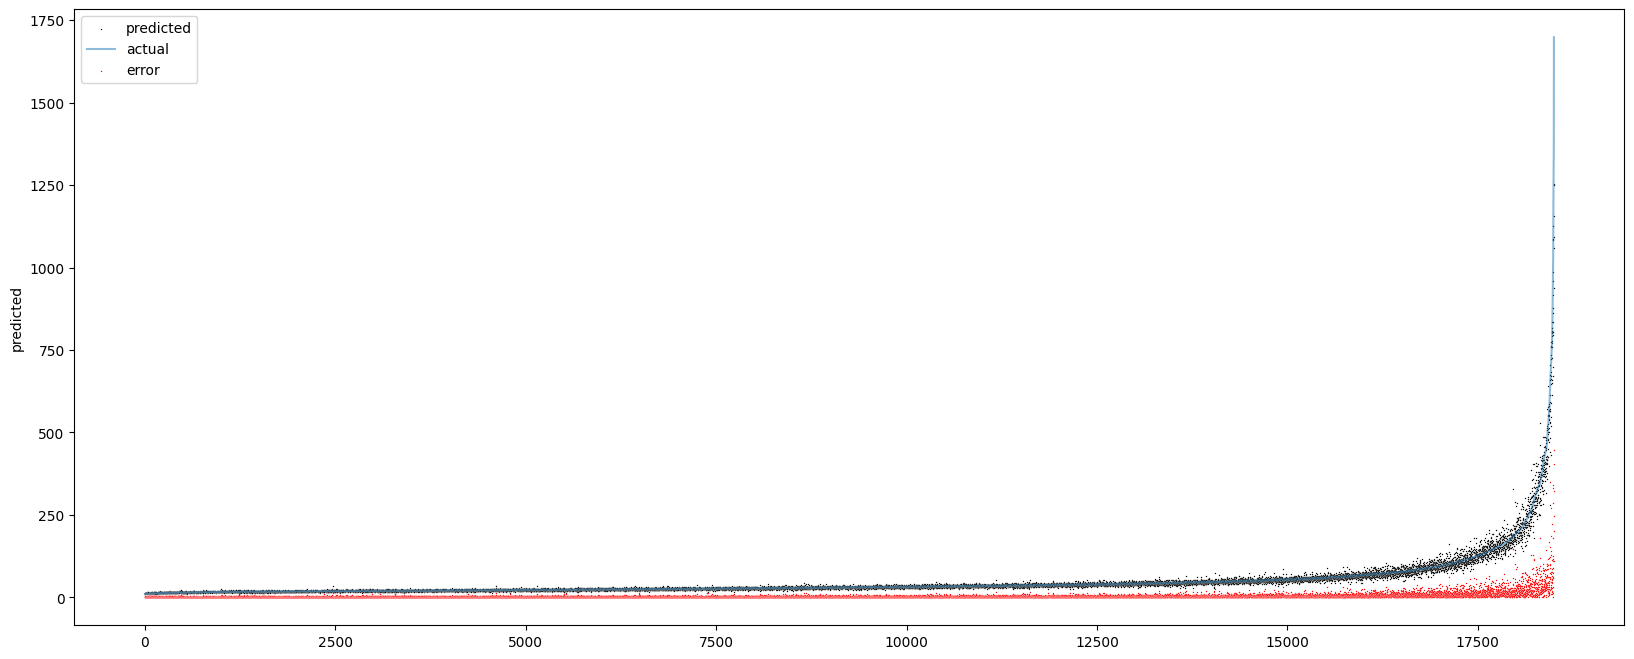

In [6]:
with open(data_dir / "selector_rfe_xgboost_300_1.pkl", "rb") as f:
    selector = pickle.load(f)
with open(data_dir / "xgboost_best_hp_2.pkl", "rb") as f:
    params = pickle.load(f)
    
X_train, y_train, X_test, y_test = tuxai_train_test_split()


df_ranks = pd.DataFrame({
    "options": X_train.columns, 
    "option_rank": selector.ranking_
}).sort_values("option_rank", ascending=True)

top_options = df_ranks[df_ranks.option_rank == 1].options.tolist()

with open(data_dir / "top_options_300_1.pkl", "wb") as f:
    pickle.dump(top_options, f, protocol=pickle.HIGHEST_PROTOCOL)

xgb_reg = xgb.XGBRegressor(**params)
xgb_reg.fit(X_train[top_options], y_train)
y_pred = xgb_reg.predict(X_test[top_options])
pprint(report(y_pred, y_test))
plot_pred_true(y_pred, y_test)

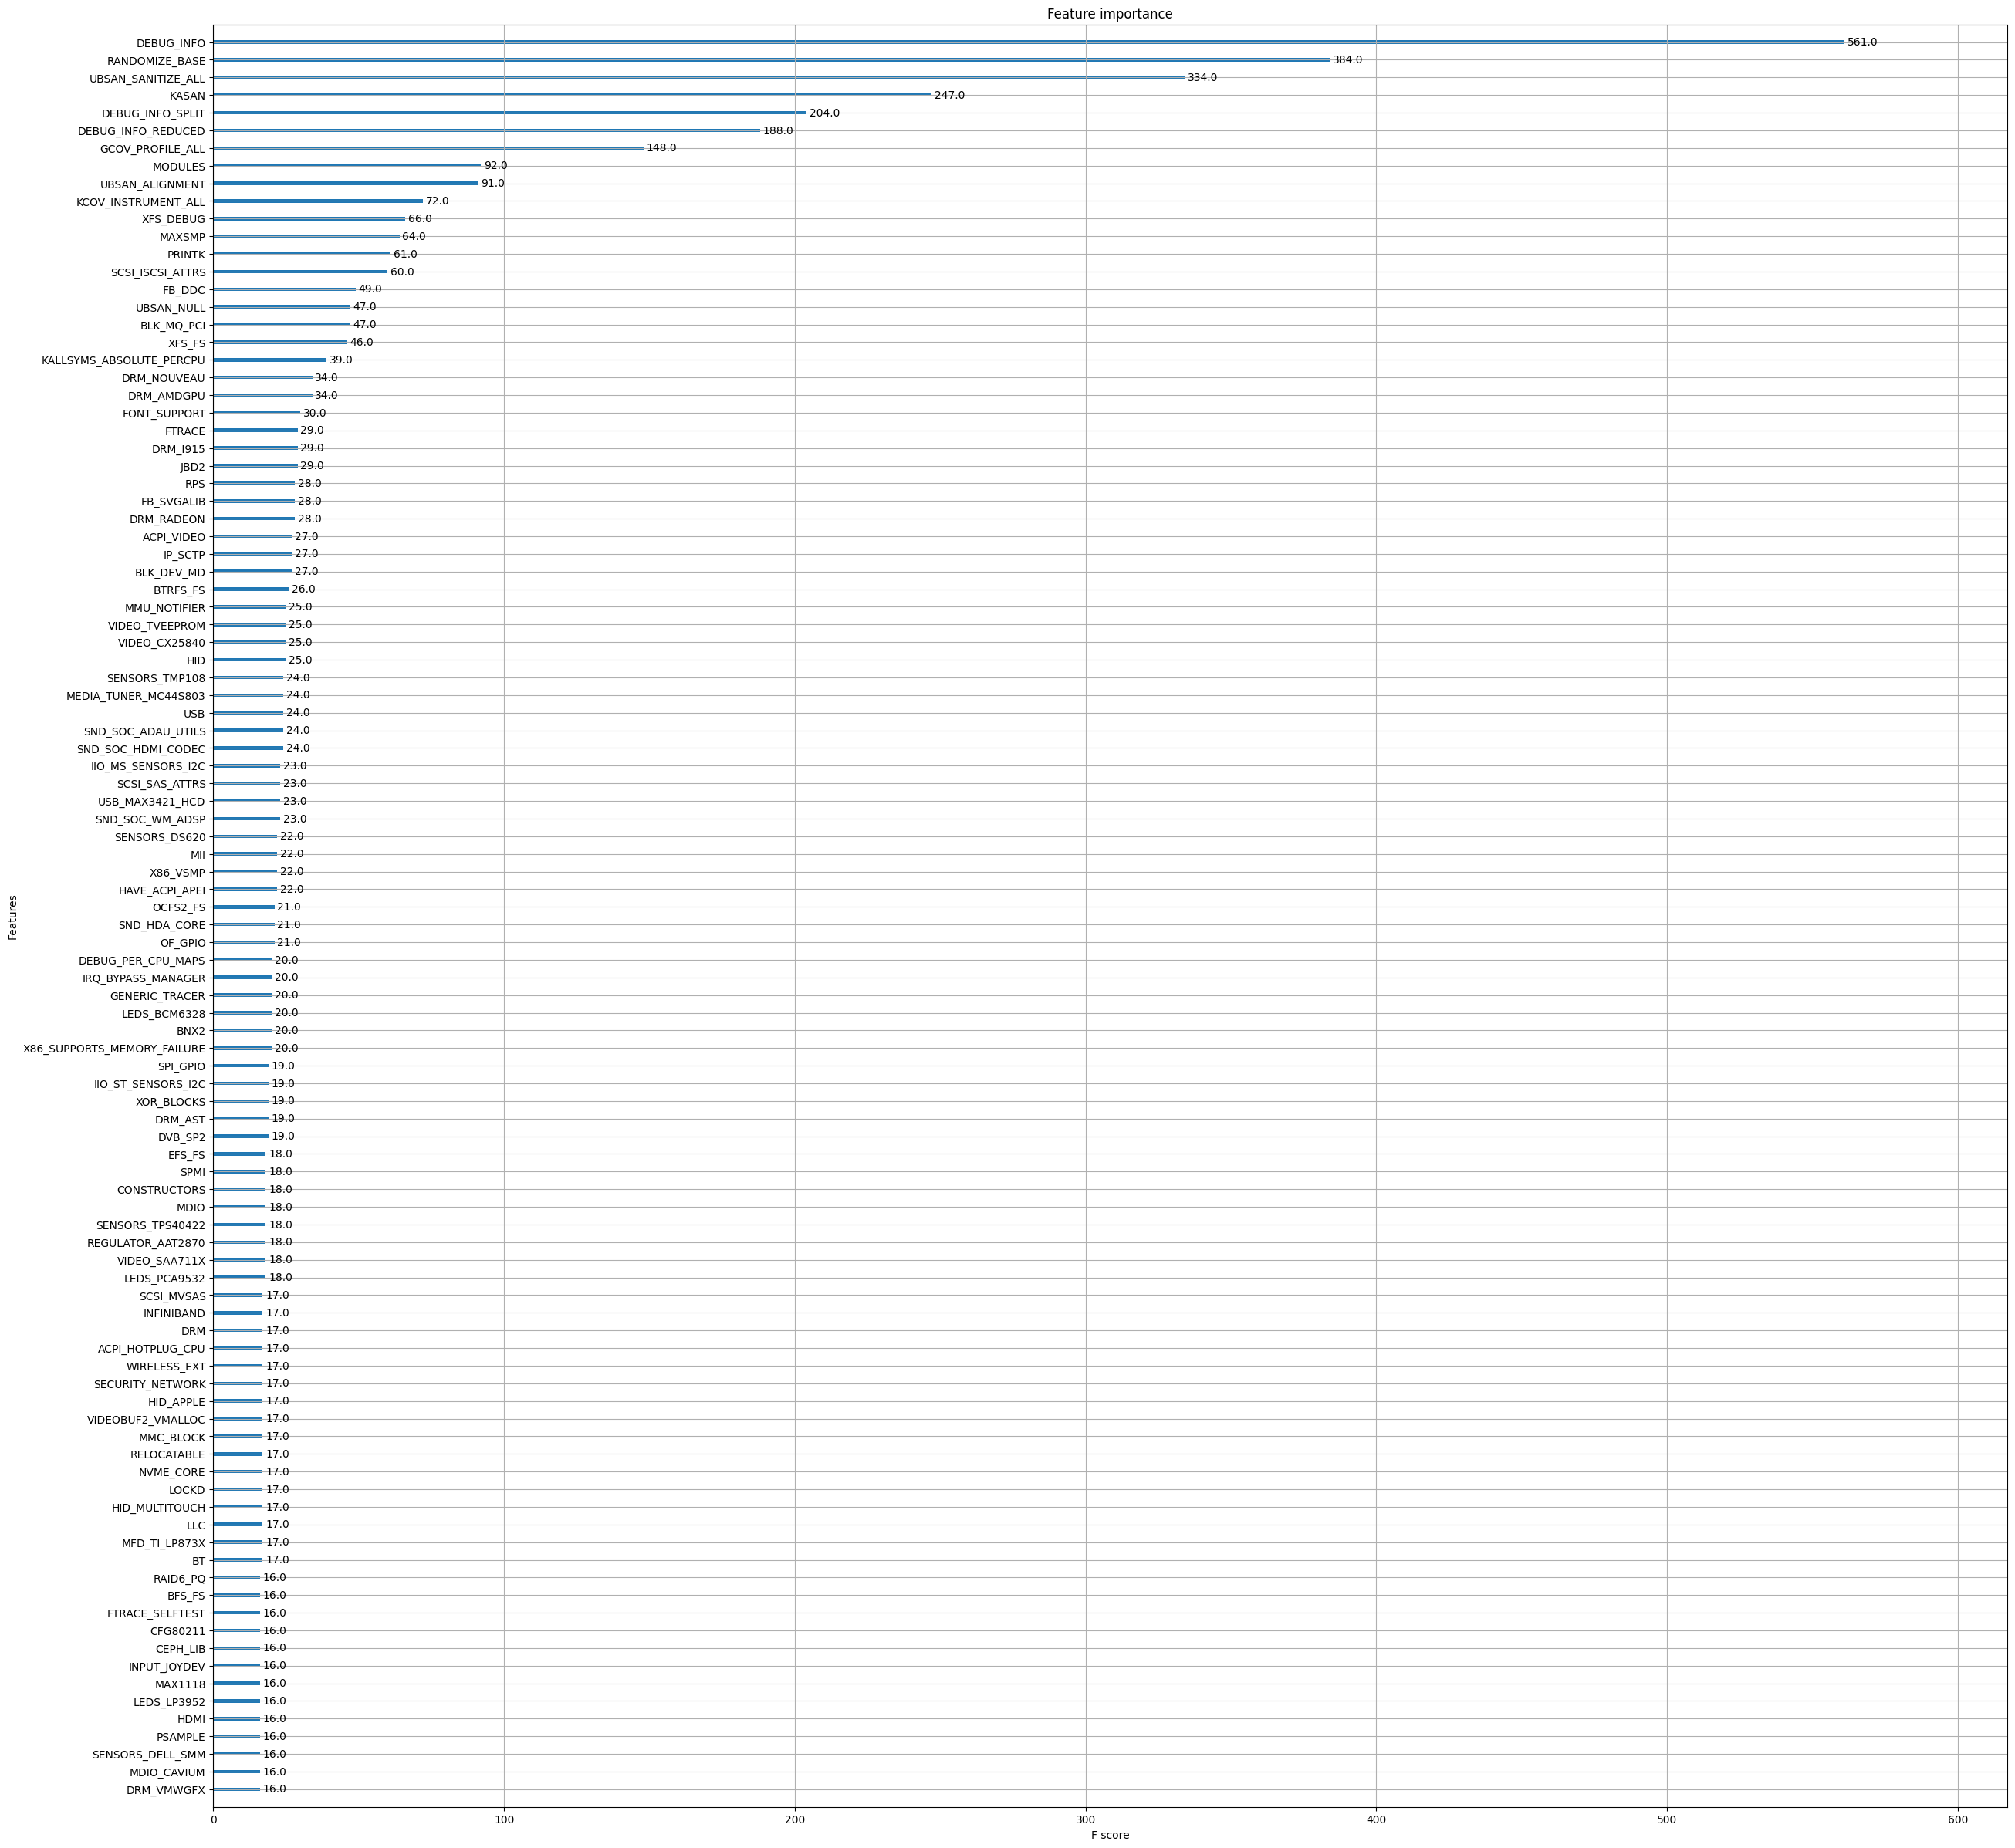

In [10]:
xgb.plot_importance(xgb_reg, max_num_features=100)
fig = plt.gcf()
fig.set_size_inches(30,30)

# Exp2 NN (300 features)

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
#from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

model = tf.keras.Sequential()
model.add(layers.Dense(1024, activation="relu", input_shape=(300,)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation="linear"))

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss=tf.keras.losses.MeanSquaredError())
model.build()
#print(model.summary())

with open(data_dir / "top_options_300_1.pkl", "rb") as f:
    top_options = pickle.load(f)
    
X_train, y_train, X_test, y_test = tuxai_train_test_split()

X_train_t = tf.convert_to_tensor(X_train[top_options])
y_train_t = tf.convert_to_tensor(y_train)

print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))
es = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto')
#with tf.device('/cpu:0'):
model.fit(X_train_t, y_train_t, validation_split=0.2, epochs=1000, batch_size=1024, shuffle=True, callbacks=[es])

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/1000
30/58 [==============>...............] - ETA: 0s - loss: 4428.3481

2022-11-18 14:33:41.393185: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


58/58 [==============================] - 1s 8ms/step - loss: 3850.6238 - val_loss: 2973.6550
Epoch 2/1000
58/58 [==============================] - 0s 6ms/step - loss: 2548.3521 - val_loss: 2144.2051
Epoch 3/1000
58/58 [==============================] - 0s 6ms/step - loss: 1784.1553 - val_loss: 1411.5289
Epoch 4/1000
58/58 [==============================] - 0s 6ms/step - loss: 1085.3488 - val_loss: 956.9026
Epoch 5/1000
58/58 [==============================] - 0s 6ms/step - loss: 710.4161 - val_loss: 649.9120
Epoch 6/1000
58/58 [==============================] - 0s 7ms/step - loss: 520.6212 - val_loss: 528.1273
Epoch 7/1000
58/58 [==============================] - 0s 6ms/step - loss: 385.7125 - val_loss: 485.6312
Epoch 8/1000
58/58 [==============================] - 0s 6ms/step - loss: 315.1805 - val_loss: 444.9810
Epoch 9/1000
58/58 [==============================] - 0s 6ms/step - loss: 269.3102 - val_loss: 367.0198
Epoch 10/1000
58/58 [==============================] - 0s 6ms/step - l

579/579 [==============================] - 1s 1ms/step
{'max_error': 680.728889465332, 'rmse': 16.50656771590275}


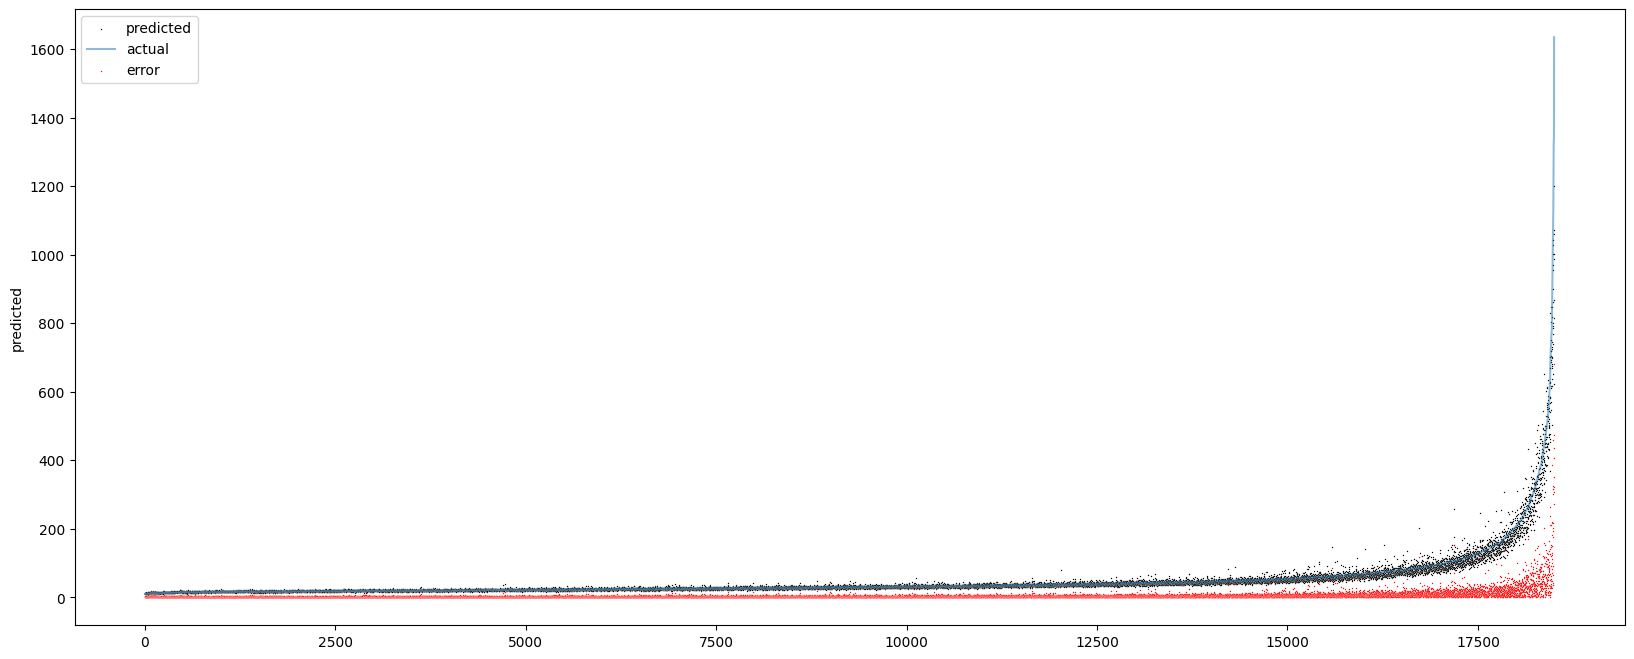

In [4]:
X_test_t = tf.convert_to_tensor(X_test[top_options])
y_test_t = tf.convert_to_tensor(y_test)
#with tf.device('/cpu:0'):
#model.evaluate(X_test_t,y_test_t)
y_pred_t = model.predict(X_test[top_options]).flatten()

pprint(report(y_pred_t, y_test_t))
plot_pred_true(y_pred_t, y_test_t)

# Exp 5: RFE(XGBOOST, 300) + NN + KerasTuner

In [18]:
import tensorflow as tf
from tensorflow.keras import layers
#from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import keras_tuner as kt

class HyperModel(kt.HyperModel):

    def build(self, hp):
        model = tf.keras.Sequential()
        model.add(layers.Dense(units=hp.Int("dense_1", min_value=10, max_value=1000, step=10), activation="relu", input_shape=(300,)))
        model.add(layers.Dropout(hp.Float("dropout_1", min_value=0.1, max_value=0.8, sampling="linear")))
        model.add(layers.Dense(units=hp.Int("dense_2", min_value=10, max_value=1000, step=10), activation="relu"))
        model.add(layers.Dropout(hp.Float("dropout_2", min_value=0.1, max_value=0.8, sampling="linear")))
        
        if hp.Boolean("third_layer"):
            model.add(layers.Dense(units=hp.Int("dense_3", min_value=10, max_value=1000, step=10), activation="relu"))
            model.add(layers.Dropout(hp.Float("dropout_3", min_value=0.1, max_value=0.8, sampling="linear")))
        
        model.add(layers.Dense(1, activation="linear"))
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss=tf.keras.losses.MeanSquaredError())
        return model

    def fit(self, hp, model, x, y, **kwargs):
        return model.fit(x, y, **kwargs,)

with open(data_dir / "top_options_300_1.pkl", "rb") as f:
    top_options = pickle.load(f)
    
X_train_t = tf.convert_to_tensor(X_train[top_options])
y_train_t = tf.convert_to_tensor(y_train)
    
hp = kt.HyperParameters()
hypermodel = HyperModel()
model = hypermodel.build(hp)

es = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto'
)

def bo_tuner():
    return kt.BayesianOptimization(
        HyperModel(),
        'val_loss',
        max_trials=500,
        num_initial_points=1,
        executions_per_trial=5,
        overwrite=True,
        directory="exp5_bo",
        project_name="tuxai_exp"
    )

def hb_tuner():
    return kt.Hyperband(
        HyperModel(),
        objective="val_loss",
        #max_epochs=1000,
        overwrite=True,
        directory="exp5_hb",
        project_name="tuxai_exp",
    )

with tf.device('/gpu:0'):
    tuner = bo_tuner()
    tuner.search(X_train_t, y_train_t, callbacks=[es], validation_split=0.2, batch_size=1024, shuffle=True, epochs=1000) #, validation_data=(x_val, y_val))

#print(model.summary())
#print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

Trial 500 Complete [00h 00m 28s]
val_loss: 212.48394470214845

Best val_loss So Far: 186.20138854980468
Total elapsed time: 08h 56m 04s
INFO:tensorflow:Oracle triggered exit


In [16]:
model = tuner.get_best_models()[0]
X_test_t = tf.convert_to_tensor(X_test[top_options])
y_test_t = tf.convert_to_tensor(y_test)
y_pred_t = model.predict(X_test[top_options]).flatten()
pprint(report(y_pred_t, y_test_t))


579/579 [==============================] - 0s 662us/step
{'max_error': 645.7365875244141, 'rmse': 16.839967808041198}
